In [1]:
import os
import math
import matplotlib.pyplot as plt
import umap
import umap.plot
import numpy as np
import pandas as pd
import seaborn as sns
import neuro_morpho_toolbox as nmt
import neuro_morpho_toolbox.plot as nmtp
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import pickle

min_max_scaler = MinMaxScaler()
plt.style.use(['science', 'no-latex'])


def reassign_region_id():
    region_used=nmt.bs.selected_regions
    origin_ccf = np.array(nmt.annotation.array[:, :, :], dtype=np.uint32)
    selected_annotaion = np.zeros_like(nmt.annotation.array, dtype=np.uint32)
    for region in region_used:
        #get its child region
        child_regions = nmt.bs.get_all_child_id(region)
        if len(child_regions) == 0:
            ix, iy, iz = np.where(origin_ccf == region)
            selected_annotaion[ix, iy, iz] = region
            continue
        for childregion in child_regions:
            ix, iy, iz = np.where(origin_ccf == childregion)
            selected_annotaion[ix, iy, iz] = region
    print('processing finished, reassign region id to its parent_id')
    return selected_annotaion

def get_region_swc(cswc,
                   annotation=nmt.annotation,
                   brain_structure=nmt.bs,
                   region_used=None):
    tp = cswc.copy()
    tp = pd.DataFrame(
        {
            "x": np.array(np.array(tp.x),dtype="int32"),
            "y": np.array(np.array(tp.y),dtype="int32"),
            "z": np.array(np.array(tp.z),dtype="int32")
        },
        index=tp.index)
    tp = tp[((tp.x >= 0) & (tp.x < annotation.size['x']) & (tp.y >= 0) &
             (tp.y < annotation.size['y']) & (tp.z >= 0) &
             (tp.z < annotation.size['z']))]

    # Add region id to the dataframe
    if region_used is None:
        region_used = nmt.bs.selected_regions
        dict_to_used = nmt.bs.dict_to_selected
    else:
        assert all([
            (i in brain_structure.level.index.tolist()) for i in region_used
        ]), "Given regions invalid. Please check 'region_used'."
        dict_to_used = {}
        for cur_region in region_used:
            child_ids = nmt.bs.get_all_child_id(cur_region)
            for i in child_ids:
                dict_to_used[i] = cur_region
    tp["region_id"] = np.array(annotation.array[tp.x, tp.y, tp.z], dtype=int)
    tp = tp[tp.region_id.isin(list(dict_to_used.keys()))]
    tp["region_id"] = np.array(tp["region_id"].map(dict_to_used), dtype=int)
    res = cswc.copy()
    res['region_id'] = 0
    res.loc[tp.index, 'region_id'] = tp['region_id']
    return res

def get_motif_regions(inmotif):
    inmotif['x']=inmotif['x']/25
    inmotif['y']=inmotif['y']/25
    inmotif['z']=inmotif['z']/25
    brregions=get_region_swc(cswc=inmotif,annotation=my_annotation)
    return brregions

def get_soma_region(infile):
    inswc=nmt.swc.neuron(infile).swc
    rootnum=inswc[inswc.parent<0].shape[0]
    if rootnum != 1:
        print('Soma error: ', infile.split('/')[-1],' ; size= ', rootnum)
        return 'error'
    soma=inswc[inswc.parent<0].copy()
    soma['x']=soma['x']/25
    soma['y']=soma['y']/25
    soma['z']=soma['z']/25
    somar=get_region_swc(cswc=soma,annotation=my_annotation)
    soma_rid=somar['region_id'].tolist()[0]
    if soma_rid >0:
        return nmt.bs.id_to_name(soma_rid)
    return 'error'

def acos(invalue):
    return math.acos(invalue)*180/math.pi

def read_motif(file,soma_region=None, level_nor=True):
    '''
    motif features
    '''
    if not os.path.exists(file):
        return False
    fmotif=pd.read_csv(file)
    fname=file.split('/')[-1]
    if fmotif.shape[0] <= 0:
        return fmotif
    # fkeys=fmotif.keys()
    max_level=max(fmotif.loc[:,'level'])
    max_dist2soma=max(fmotif.loc[:,'dist2soma'])
    max_path_dist2soma=max(fmotif.loc[:,'path_dist2soma'])
    # print(fmotif.shape)
    fmotif.drop(index=fmotif[fmotif.pathlength==0].index.to_list(),inplace=True)
    fmotif.drop(index=fmotif[fmotif.length==0].index.to_list(),inplace=True)
    fmotif.drop(index=fmotif[fmotif.radius==0].index.to_list(),inplace=True)
    fmotif.drop(index=fmotif[fmotif.lcpathlength==0].index.to_list(),inplace=True)
    fmotif.drop(index=fmotif[fmotif.type>4].index.to_list(),inplace=True)
    # print(fmotif.shape)
    #get motif region
    motif=get_motif_regions(fmotif)
    # motif=motif[motif.region_id>0]
    namelist=[]
    sregions=[]
    for n in motif.index:
        namelist.append(fname+'+'+str(motif.loc[n,'id']))
        if soma_region is not None:
            sregions.append(soma_region)
    motif['name']=namelist
    if soma_region is not None:
        motif['soma_region']=sregions
    if level_nor:
        motif['level']=fmotif['level']/max_level
    motif['dist2soma']=100*motif['dist2soma']/max_dist2soma
    motif['path_dist2soma']=100*motif['path_dist2soma']/max_path_dist2soma
    motif['radius_io']=motif['lcradius']/motif['radius']
    motif['radius_oa']=motif['lcradius']/(motif['rcradius']+motif['lcradius'])
    motif['io_len_ratio']=motif['lclength']/motif['length']
    motif['lr_len_ratio']=motif['lclength']/(motif['lclength']+motif['rclength'])
    motif['io_pathlen_ratio']=motif['lcpathlength']/motif['pathlength']
    motif['lr_pathlen_ratio']=motif['lcpathlength']/(motif['lcpathlength']+motif['rcpathlength'])
    motif['in_contraction']=motif['length']/motif['pathlength']
    motif['left_contraction']=motif['lclength']/motif['lcpathlength']
    motif['right_contraction']=motif['rclength']/motif['rcpathlength']
    motif['angle']=np.array(motif['angle'].map(acos), dtype=int)
    motif['angle_io1']=np.array(motif['angle_io1'].map(acos), dtype=int)
    motif['angle_io1_remote']=np.array(motif['angle_io1_remote'].map(acos), dtype=int)
    motif['angle_io2']=np.array(motif['angle_io2'].map(acos), dtype=int)
    motif['angle_io2_remote']=np.array(motif['angle_io2_remote'].map(acos), dtype=int)
    motif['angle_remote']=np.array(motif['angle_remote'].map(acos), dtype=int)
    # motif['subtree_len_ratio']=fmotif['lslength']/(fmotif['lslength']+fmotif['rslength'])
    # motif['subtree_path_len_ratio']=fmotif['lspathlength']/(fmotif['lspathlength']+fmotif['rspathlength'])
    # motif['subtree_tip_ratio']=fmotif['lstips']/(fmotif['lstips']+fmotif['rstips'])
    return motif
ccf_reassigned_f='../ccf_reassigned.pickle'
if os.path.exists(ccf_reassigned_f):
    with open(ccf_reassigned_f,'rb') as f:
        my_annotation=pickle.load(f)
else:
    print('reassign start... will take a long time.')
    selected_annotaion=reassign_region_id()
    my_annotation=nmt.annotation
    my_annotation.array=selected_annotaion
    with open(ccf_reassigned_f,'wb') as f:
        pickle.dump(my_annotation,f)
# comparing various branching units
def get_degree(tswc):
    tswc['degree'] = tswc['parent'].isin(tswc.index).astype('int')
    # print(tswc['degree'])
    n_child = tswc.parent.value_counts()
    n_child = n_child[n_child.index.isin(tswc.index)]
    tswc.loc[n_child.index, 'degree'] = tswc.loc[n_child.index, 'degree'] + n_child
    return tswc
def get_rid(swc):
    '''
    Find root node.
    '''
    rnode=swc[((swc['parent']<0) & (swc['type']<=1))]
    if rnode.shape[0]<1:
        return -1
    return rnode.index[0]
def get_hid(swc):
    '''
    Find head node.
    '''
    # print(swc)
    rnode=swc[swc['parent']<0]
    # print(rnode)
    if rnode.shape[0]<1:
        return -1
    return rnode.index[0]
def get_keypoint(swc, rid=None):
    if rid is None:
        rid = get_hid(swc)
    #print(swc.shape)
    swc=get_degree(swc)
    idlist = swc[((swc.degree!=2) | (swc.index==rid))].index.tolist()
    return idlist
def get_bifurcation(swc,rid=None):
    if rid is None:
        rid = get_hid(swc)
    #print(swc.shape)
    swc=get_degree(swc)
    idlist=swc[((swc.degree>2) & (swc.index!=rid))].index.tolist()
    return idlist
def swc2branches(swc):
    '''
    reture branch list of a swc
    '''
    keyids=get_keypoint(swc)
    branches=[]
    for key in keyids:
        if swc.loc[key,'parent']<0:
            continue
        branch=[]
        branch.append(key)
        pkey=swc.loc[key,'parent']
        while True:
            branch.append(pkey)
            if pkey in keyids:
                break
            key=pkey
            if key not in swc.index:
                break
            pkey=swc.loc[key,'parent']
        branches.append(branch)
    return branches
def swc_plot(file,direction='XY',title=None,linewidth=2,shift=True,xlim=None,ylim=None):
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    colors=['white','black','red','blue','magenta','green']
    swc=nmt.swc.neuron(file).swc
    if shift:
        swc.loc[:,'x']-=swc.loc[:,'x'].min()
        swc.loc[:,'y']-=swc.loc[:,'y'].min()
        swc.loc[:,'z']-=swc.loc[:,'z'].min()
    swc_brs=swc2branches(swc)
    bifur_index=get_bifurcation(swc)
    # print(bifur_index)
    bifur_color='green'
    if len(bifur_index) ==1:
        Bx=swc.loc[bifur_index,'x']
        By=swc.loc[bifur_index,'y']
        Bz=swc.loc[bifur_index,'z']
    for br in swc_brs:
        br_color=colors[int(swc.loc[br[0],'type'])]
        br_coords=swc.loc[br,['x','y','z']].copy()
        Xe=br_coords['x'].to_list()
        Ye=br_coords['y'].to_list()
        Ze=br_coords['z'].to_list()
        if direction=='YZ':
            ax.plot(Ye, Ze, c=br_color,linewidth=linewidth)
            ax.plot(By, Bz, c=bifur_color,marker='o',markersize=12)
            ax.set_xlabel('Y',fontsize=10)
            ax.set_ylabel('Z',fontsize=10) 
        elif direction=='XZ':
            ax.plot(Xe, Ze, c=br_color,linewidth=linewidth)
            ax.plot(Bx, Bz, c=bifur_color,marker='o',markersize=12)
            ax.set_xlabel('X',fontsize=10)
            ax.set_ylabel('Z',fontsize=10) 
        else:
            ax.plot(Xe, Ye, c=br_color,linewidth=linewidth)
            ax.plot(Bx, By, c=bifur_color,marker='o',markersize=12)
            ax.set_xlabel('X',fontsize=10)
            ax.set_ylabel('Y',fontsize=10)
    hid=get_hid(swc=swc)
    if hid is not None:
        head_coord=swc.loc[hid,['x','y','z']].copy()
        if direction=='YZ':
            ax.plot(head_coord['y'], head_coord['z'], c='black',marker='o',markersize=10)
        elif direction=='XZ':
            ax.plot(head_coord['x'], head_coord['z'], c='black',marker='o',markersize=10)
        else:
            ax.plot(head_coord['x'], head_coord['y'], c='black',marker='o',markersize=10)
    if title is not None:
        ax.set_title(title,fontsize=12)
    if xlim is not None:
        ax.set_xlim(xlim) 
    if ylim is not None:
        ax.set_ylim(ylim)      
    return fig, ax
def motifs_plot(files,direction='XY',title=None,linewidth=2,shift=True,fontsize=12,compare=False,markersize=12,xylabel=True):
    fsize=len(files)
    basic_width=5
    colors=['white','black','red','blue','magenta','green']
    fig, cax = plt.subplots(1,fsize, figsize=(fsize*basic_width,basic_width),dpi=100)
    xmax=0
    ymax=0
    zmax=0
    swcs=[]
    for file in files:
        swc=nmt.swc.neuron(file).swc
        if shift:
            swc.loc[:,'x']-=swc.loc[:,'x'].min()
            swc.loc[:,'y']-=swc.loc[:,'y'].min()
            swc.loc[:,'z']-=swc.loc[:,'z'].min()
        xmax=swc.loc[:,'x'].max() if swc.loc[:,'x'].max() > xmax else xmax
        ymax=swc.loc[:,'y'].max() if swc.loc[:,'y'].max() > ymax else ymax
        zmax=swc.loc[:,'z'].max() if swc.loc[:,'z'].max() > zmax else zmax
        swcs.append(swc)
        
    for i,swc in enumerate(swcs):
        ax = cax[i]
        ax.tick_params(labelsize=fontsize)
        # swc=nmt.swc.neuron(file).swc
        # print(swc)
        # print('Now swc: ',i)
        swc_brs=swc2branches(swc)
        bifur_index=get_bifurcation(swc)
        # print(bifur_index)
        bifur_color='green'
        if len(bifur_index) ==1:
            Bx=swc.loc[bifur_index,'x']
            By=swc.loc[bifur_index,'y']
            Bz=swc.loc[bifur_index,'z']
        for br in swc_brs:
            br_color=colors[int(swc.loc[br[0],'type'])]
            br_coords=swc.loc[br,['x','y','z']].copy()
            Xe=br_coords['x'].to_list()
            Ye=br_coords['y'].to_list()
            Ze=br_coords['z'].to_list()
            if direction=='YZ':
                ax.plot(Ye, Ze, c=br_color,linewidth=linewidth)
                ax.plot(By, Bz, c=bifur_color,marker='o',markersize=markersize)
                xamax=ymax
                yamax=zmax
                xlabel_text='Y'
                ylabel_text='Z'
            elif direction=='XZ':
                ax.plot(Xe, Ze, c=br_color,linewidth=linewidth)
                ax.plot(Bx, Bz, c=bifur_color,marker='o',markersize=markersize)
                xamax=xmax
                yamax=zmax
                xlabel_text='X'
                ylabel_text='Z'
            else:
                ax.plot(Xe, Ye, c=br_color,linewidth=linewidth)
                ax.plot(Bx, By, c=bifur_color,marker='o',markersize=markersize)
                xamax=xmax
                yamax=ymax
                xlabel_text='X'
                ylabel_text='Y'
        
            hid=get_hid(swc=swc)
        if hid is not None:
            head_coord=swc.loc[hid,['x','y','z']].copy()
            if direction=='YZ':
                ax.plot(head_coord['y'], head_coord['z'], c='black',marker='o',markersize=markersize)
            elif direction=='XZ':
                ax.plot(head_coord['x'], head_coord['z'], c='black',marker='o',markersize=markersize)
            else:
                ax.plot(head_coord['x'], head_coord['y'], c='black',marker='o',markersize=markersize)
        if compare:
            ax.set_xlim([-10,xamax+10])
            ax.set_ylim([-10,yamax+10])

        if xylabel:
            ax.set_xlabel(xlabel_text,fontsize=fontsize)
            ax.set_ylabel(ylabel_text,fontsize=fontsize)
        else:
            ax.set_xlabel('')
            ax.set_ylabel('')
        # ax.set_xlabel(xlabel_text,fontsize=fontsize)
        # ax.set_ylabel(ylabel_text,fontsize=fontsize)  
        if title is not None:
            ax.set_title(title[i],fontsize=fontsize)
    plt.tight_layout()
    return fig, ax


/Users/jiangshengdian/opt/anaconda3/envs/py37/lib/python3.7/site-packages/neuro_morpho_toolbox-0.1-py3.7.egg/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.74
Loading CCF brain structure data...
Loading time: 0.01
Loading flat_map ...
Loading time: 5.48


In [17]:
from scipy import misc
from PIL import Image
from libtiff import TIFF

figcenter='./internal_motif_figs/'

def tiff_to_image_array(tiff_image_name, out_folder, out_type):

    tif = TIFF.open(tiff_image_name, mode="r")
    idx = 0
    for im in list(tif.iter_images()):
        im_name = out_folder + str(idx) + out_type
        misc.imsave(im_name, im)
        print(im_name, 'successfully saved!!!')
        idx = idx + 1
    return
def Img2TIFF(infile,compression=None):
    #get imgpath and img_basename
    inimgname = infile.split('/')[-1]
    inimgbasename = inimgname.split('.')[0]
    imgpath = infile.split(inimgbasename)[0]
    outfile = imgpath + inimgbasename + '.tiff'
    out_tiff = TIFF.open(outfile, mode='w')
    in_image_array = Image.open(infile)
    # img = in_image_array.resize((480, 480), Image.ANTIALIAS)
    out_tiff.write_image(in_image_array, compression=compression, write_rgb=True)
    out_tiff.close()
    print('save tiff :', outfile)
    return

(<Figure size 288x288 with 1 Axes>, <AxesSubplot:xlabel='Y', ylabel='Z'>)

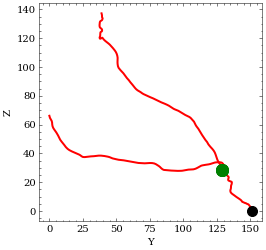

In [653]:
btest='../motif/brdb/18454_00139.eswc/'+'29_motif.eswc'
swc=nmt.swc.neuron(btest).swc
tswc=get_keypoint(swc)
swc_plot(btest,direction='YZ')

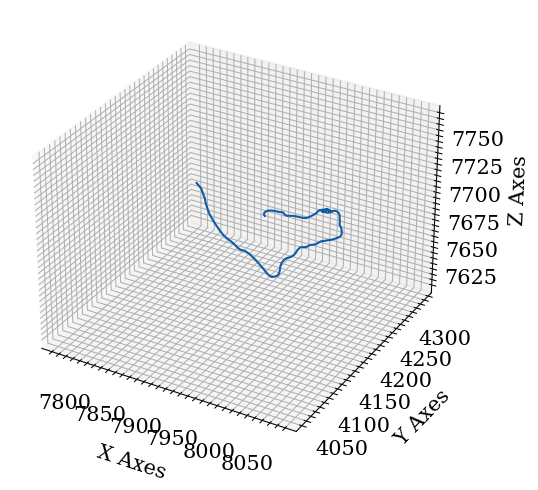

In [428]:
from mpl_toolkits.mplot3d import axes3d

fig=plt.figure(figsize=(4,4),dpi=150)

ax = plt.axes(projection='3d')
file='../motif/brdb/191807_4923_x7499_y24194.eswc/167_motif.eswc'
swc=nmt.swc.neuron(file).swc
swc_brs=swc2branches(swc)
colors=['white','black','red','blue','magenta','green']
for br in swc_brs:
    br_color=colors[int(swc.loc[br[0],'type'])]
    br_coords=swc.loc[br,['x','y','z']].copy()
    Xe=br_coords['x'].to_list()
    Ye=br_coords['y'].to_list()
    Ze=br_coords['z'].to_list()
ax.plot3D(Xe,Ye,Ze,)
ax.set_xlabel('X Axes')
ax.set_ylabel('Y Axes')
ax.set_zlabel('Z Axes')

plt.show()

In [2]:
# get cell type
r1741_type='/Users/jiangshengdian/Desktop/Daily/Reconstructions/seu_allen_data/1741_Celltype.csv'
r1741df=pd.read_csv(r1741_type,index_col=['name'])
swcdir='../motif/1780'
motif_dir='../motif/branch'
celltype_new='../1780_cell_type.csv'
allpath=[]
for root,dirs,files in os.walk(motif_dir):
    for mfile in files:
        if os.path.splitext(mfile)[1] != '.csv':
            continue
        file_in=os.path.join(root,mfile)
        allpath.append(file_in)
fromFile=True
if fromFile and os.path.exists(celltype_new):
    validated_cells=pd.read_csv(celltype_new,index_col=['name'])
else:
    namelist=[]
    somalist=[]
    for findex,fpath in enumerate(allpath):
        fname=fpath.split('/')[-1]
        fbname=fname.split('.eswc')[0]
        namelist.append(fname)
        if fbname in r1741df.index:
            soma_region=r1741df.loc[fbname,'Soma_region']
        else:
            swcf=os.path.join(swcdir,fbname+'.eswc')
            soma_region=get_soma_region(swcf)
        somalist.append(soma_region)
    soma_region_df=pd.DataFrame({"name":namelist,"region":somalist})
    validated_cells=soma_region_df[(soma_region_df.region != 'error') & (soma_region_df.region != 'fiber tracts')].copy()
    validated_cells.set_index(['name'],inplace=True)
    validated_cells.to_csv(celltype_new)
# print(validated_cells.value_counts().head(10))

In [2]:
# get motif
allf='../all_motif_raw.csv'
FromFile=True
if FromFile and os.path.exists(allf):
    all_motif_raw=pd.read_csv(allf,index_col=['name'])
else:
    all_motif_raw=pd.DataFrame()
    for findex,fpath in enumerate(allpath):
        if fpath.split('/')[-1] not in validated_cells.index:
            print('skip:',fpath.split('/')[-1])
            continue
        cellregion=validated_cells.loc[fpath.split('/')[-1],'region']
        fmotif=read_motif(fpath,soma_region=cellregion,level_nor=False)
        # break
        if fmotif.shape[0] <= 0:
            print('no motifs in ',fpath.split('/')[-1])
            continue
        all_motif_raw=pd.concat([all_motif_raw, fmotif],sort=True,ignore_index=True)
    all_motif_raw.dropna(inplace=True)
    all_motif_raw.set_index('name',inplace=True)
    all_motif_raw.to_csv(allf)
all_motif=all_motif_raw.drop(['id', 'parent_id', 'x', 'y', 'z','rslength', 'rspathlength', 'rstips','lslength', 'lspathlength',
       'lstips'],axis=1).copy()
all_motif.keys()
# all_motif.drop(['dist2soma','path_dist2soma','subtree_len_ratio', 'subtree_path_len_ratio', 'subtree_tip_ratio','x','y','z'],axis=1,inplace=True)

Index(['angle', 'angle_io1', 'angle_io1_remote', 'angle_io2',
       'angle_io2_remote', 'angle_remote', 'depth', 'dist2soma', 'height',
       'in_contraction', 'io_len_ratio', 'io_pathlen_ratio', 'lclength',
       'lcpathlength', 'lcradius', 'left_contraction', 'length', 'level',
       'lr_len_ratio', 'lr_pathlen_ratio', 'path_dist2soma', 'pathlength',
       'radius', 'radius_io', 'radius_oa', 'rclength', 'rcpathlength',
       'rcradius', 'region_id', 'right_contraction', 'soma_region', 'type',
       'width'],
      dtype='object')

In [ ]:
'''branch region'''
all_motif=all_motif[all_motif.region_id>0]
all_motif['br_region']=list(map(nmt.bs.id_to_name,all_motif['region_id'].to_list()))
all_motif.drop(['region_id'],axis=1,inplace=True)

In [6]:
TH=['AD','AM','AV','CL','CM','IAD','LD','LGd','LHA','LP','MD','MG','MM','PCN','PF','PIL','PO','POL','PR','PVT',
   'PoT','RE','RT','SGN','SMT','SSp','SSp-bfd','SSp-ll','SSp-m','SSp-n','SSp-tr','SSp-ul','SSp-un','TH','VAL','VM',
   'VPL','VPLpc','VPM','VPMpc']
CTX=['ACAd','ACAv','AId','AIp','AIv','AON','AON','AUDd','AUDpo','AUDv','BLA','BMA','CA1','CA3','CLA','COAp','HPF','DG',
    'ECT','ENTl','ENTm','EPd','FRP','GU','IG','ILA','MOB','MOp','MOs','ORBl','ORBm','ORBvl','PIR','PL','POST','PRoS',
    'RSPagl','RSPd','RSPv','SSs','SUB','TEa','TR','VISC','VISa','VISal','VISam','VISl','VISli','VISp','VISpm',
    'VISpor','VISrl']
CNU=['ACB','BST','CEA','CP','FS','GPe','GPi','LSr','LSv','OT','PAL','PAR','PRE','SI']
all_motif.loc[:,'brain_region']= 'Other'
all_motif.loc[all_motif['soma_region'].isin(CNU),'brain_region']= 'CNU'
all_motif.loc[all_motif['soma_region'].isin(CTX),'brain_region']= 'CTX'
all_motif.loc[all_motif['soma_region'].isin(TH),'brain_region']= 'TH'
all_motif.to_csv('../ana_internal_motif_fea.csv')

2022-09-04: 不对成性量对（v1, v2）可以改成(v1+v2, abs(v1-v2))

1. axon level小的时候有，差异多大，大的时候没有；在不同维度上变化
2. level与level之间的差异性有多大，（类间距计算，和降维一致）
3. dendrite
4.  Hierarchy clustering 效果要更好
5.  不同方法对应的评估手段；故事逻辑

2022-09-16
1. motif在不同level上的分布是否一致
2. 计算motif不同类别在整体数据中的占比，这里使用pie plot
3. motif viz
4. dendrite单独讲
5. Thalamus subtype （soma region）

In [573]:
# 6 features
new_motif=all_motif[['angle', 'angle_io1', 'angle_io2','lclength','length','rclength',
                    'level','soma_region', 'brain_region','type']].copy()
             
new_motif['angle_io_sum']=new_motif['angle_io1']+new_motif['angle_io2']
new_motif['angle_io_abs']=(new_motif['angle_io1']-new_motif['angle_io2']).abs()
new_motif['child_len_sum']=new_motif['lclength']+new_motif['rclength']
new_motif['child_len_abs']=(new_motif['lclength']-new_motif['rclength']).abs()
new_motif.drop(['angle_io1', 'angle_io2','lclength','rclength'],axis=1,inplace=True)
axon_motif=new_motif[(new_motif.type ==2)&(new_motif.brain_region != 'Other')].copy()
axon_motif.drop(['type'],axis=1,inplace=True)

In [7]:
# all features
new_motif=all_motif[['angle', 'angle_io1', 'angle_io2','lclength','length','rclength',
                    'in_contraction', 'left_contraction','right_contraction',
                    'depth','height','width', 'pathlength','rcpathlength','lcpathlength',
                    'angle_remote','angle_io1_remote','angle_io2_remote',
                    'level','soma_region', 'brain_region','type']].copy()
                    
new_motif['angle_io_sum']=new_motif['angle_io1']+new_motif['angle_io2']
new_motif['angle_io_abs']=(new_motif['angle_io1']-new_motif['angle_io2']).abs()
new_motif['angle_ior_sum']=new_motif['angle_io1_remote']+new_motif['angle_io2_remote']
new_motif['angle_ior_abs']=(new_motif['angle_io1_remote']-new_motif['angle_io2_remote']).abs()

new_motif['child_len_sum']=new_motif['lclength']+new_motif['rclength']
new_motif['child_len_abs']=(new_motif['lclength']-new_motif['rclength']).abs()

new_motif['child_contraction_mean']=(new_motif['left_contraction']+new_motif['right_contraction'])/2
new_motif['child_contraction_abs']=(new_motif['left_contraction']-new_motif['right_contraction']).abs()
new_motif['child_plen_sum']=new_motif['lcpathlength']+new_motif['rcpathlength']
new_motif['child_plen_abs']=(new_motif['lcpathlength']-new_motif['rcpathlength']).abs()

new_motif['volume']=new_motif['depth']*new_motif['height']*new_motif['width']
new_motif.drop(['angle_io1', 'angle_io2','lclength','rclength','left_contraction','right_contraction',
              'angle_io1_remote', 'angle_io2_remote','lcpathlength','rcpathlength'],axis=1,inplace=True)

only angle features

In [355]:
used_motif=new_motif[['angle','angle_remote', 'level', 'soma_region', 'brain_region', 'angle_io_sum',
       'angle_io_abs', 'angle_ior_sum', 'angle_ior_abs']].copy()
# axon_motif_raw.drop(['type'],axis=1,inplace=True)

only size features

In [8]:
used_motif=new_motif[['length', 'in_contraction', 'depth', 'height', 'width',
       'pathlength', 'level', 'soma_region', 'brain_region',
       'type', 'child_len_sum', 'child_len_abs',
       'child_contraction_mean', 'child_contraction_abs', 'child_plen_sum',
       'child_plen_abs', 'volume']].copy()
# for axon
axon_motif=used_motif[(used_motif.type == 2)&(used_motif.brain_region != 'Other')].copy()
# all_axon_motif=new_motif[(new_motif.type ==2)&(new_motif.brain_region == 'Thalamus')].copy()
# axon_motif=new_motif[(new_motif.type ==2)].copy()
# all_axon_motif.drop(['type'],axis=1,inplace=True)
# For dendrite
# axon_motif=used_motif[(used_motif.type >2)&(used_motif.brain_region != 'Other')].copy()

axon_motif.drop(['type'],axis=1,inplace=True)

(8808, 13)


/Users/jiangshengdian/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



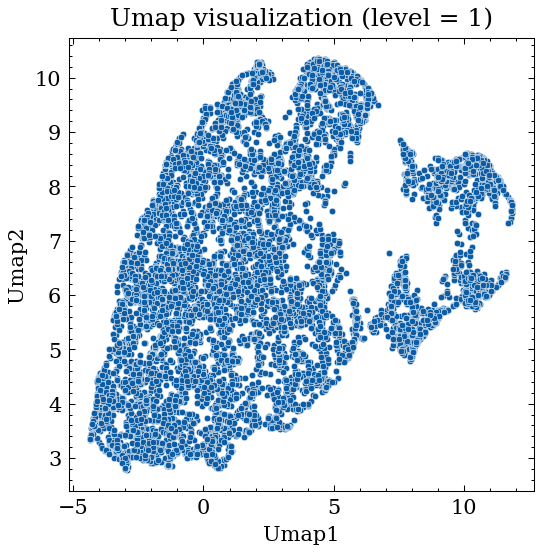

In [18]:
al=1
# axon_motif=all_axon_motif.copy()
level_motif=axon_motif[(axon_motif.level>=al) & (axon_motif.level<=al+2)].copy()
motif_values=level_motif.drop(['level','soma_region', 'brain_region'],axis=1).values
print(motif_values.shape)
stscale=StandardScaler()
stscale.fit(motif_values)
motif_s=stscale.fit_transform(motif_values)
base_umap=umap.UMAP(n_neighbors=25,min_dist=0,random_state=3)
base_umap.fit(motif_s)
level_embedding=base_umap.fit_transform(motif_s)
# level_embedding = umap.UMAP(n_neighbors=15,min_dist=0,random_state=3).fit_transform(motif_s)

level_motif['umap1']=level_embedding[:,0]
level_motif['umap2']=level_embedding[:,1]

fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
sns.scatterplot(data=level_motif,x='umap1',y='umap2',s=10,palette="deep")
plt.xlabel('Umap1')
plt.ylabel('Umap2')
plt.title('Umap visualization (level = '+str(al)+')')
plt.show()

(11752, 13)


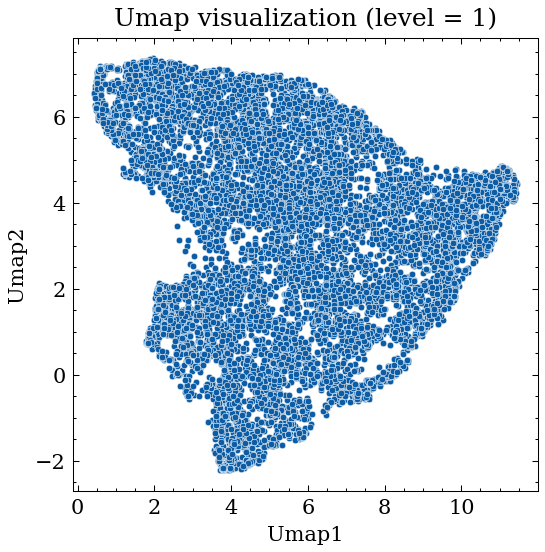

In [712]:
# high level data
high_level_motif=axon_motif[(axon_motif.level>14) & (axon_motif.level<=15)].copy()
high_motif_values=high_level_motif.drop(['level','soma_region', 'brain_region'],axis=1).values
print(high_motif_values.shape)
high_motif_s=stscale.fit_transform(high_motif_values)
high_level_embedding = base_umap.fit_transform(high_motif_s)
high_level_motif['umap1']=high_level_embedding[:,0]
high_level_motif['umap2']=high_level_embedding[:,1]


fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
sns.scatterplot(data=high_level_motif,x='umap1',y='umap2',s=10,palette="deep")
plt.xlabel('Umap1')
plt.ylabel('Umap2')
plt.title('Umap visualization (level = '+str(al)+')')
plt.show()

<AxesSubplot:>

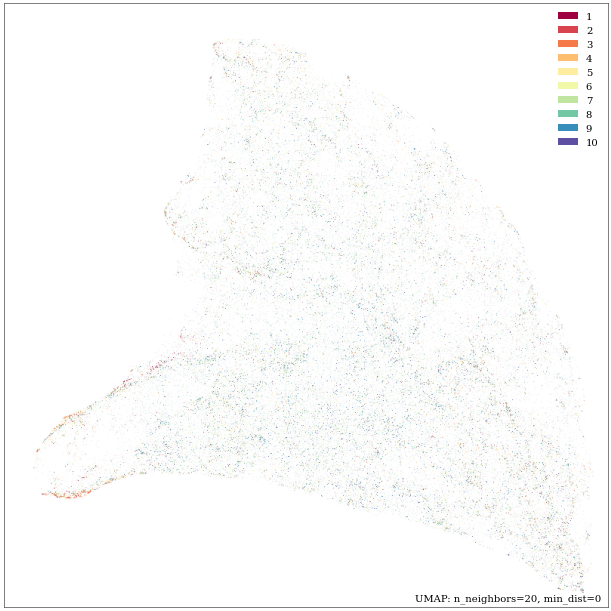

In [484]:
#umap plot
mapper = umap.UMAP(min_dist=0,n_neighbors=20,random_state=3).fit(level_motif_s)
# umap.plot.points(mapper)
umap.plot.points(mapper,labels=level_motif['level'])

In [13]:
umap.plot.points(mapper,labels=level_motif['level'])

NameError: name 'mapper' is not defined

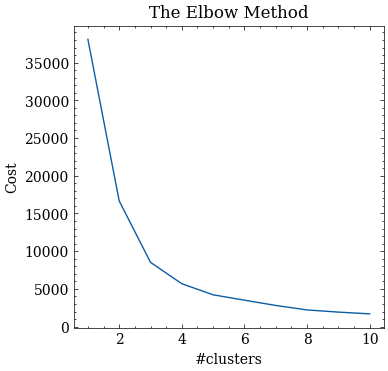

In [93]:
cost = []#初始化损失（距离）值
for i in range(1,11):#尝试不同的K值
    kmeans = KMeans(n_clusters= i ,init='k-means++', random_state =3)
    kmeans.fit(level_embedding)
    cost.append(kmeans.inertia_)#inerita_是我们选择的方法，其作用相当于损失函数

fig=plt.figure(figsize=(4,4),dpi=100)
plt.subplot(111)
plt.plot(range(1,11),cost)
plt.title('The Elbow Method')
plt.ylabel('Cost')
plt.xlabel('#clusters')
plt.show()

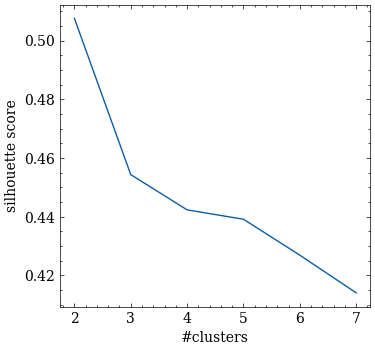

In [19]:
cost = []#初始化损失（距离）值
for i in range(2,8):#尝试不同的K值
    kmeans = KMeans(n_clusters= i ,init='k-means++', random_state =3)
    kmeans.fit(level_embedding)
    sc_score = silhouette_score(level_embedding, kmeans.labels_, metric="euclidean")
    cost.append(sc_score)#inerita_是我们选择的方法，其作用相当于损失函数

fig=plt.figure(figsize=(4,4),dpi=100)
plt.subplot(111)
plt.plot(range(2,8),cost)
# plt.title('轮廓系数')
plt.ylabel('silhouette score')
plt.xlabel('#clusters')
plt.show()

Estimated number of clusters: 4
Estimated number of noise points: 257


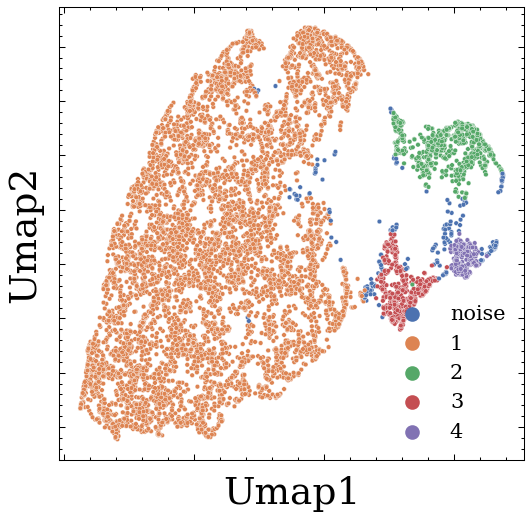

save tiff : ./internal_motif_figs/axonal_motif_clustering.tiff


In [34]:
#HDBSCAN
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=75, prediction_data=True).fit(level_embedding)
# clusterer = hdbscan.HDBSCAN(min_cluster_size=127, prediction_data=True).fit(level_embedding)
# clusterer.fit(level_embedding)
level_motif['Motif']=clusterer.labels_+1
kclusters= len(set(clusterer.labels_)) - (1 if -1 in clusterer.labels_ else 0)

print("Estimated number of clusters: %d" % kclusters)
n_noise_ = list(clusterer.labels_).count(-1)
print("Estimated number of noise points: %d" % n_noise_)
centers=np.zeros([kclusters,2])
for c in np.arange(0,kclusters):
    tmpdf=level_motif[level_motif['Motif']==(c+1)].copy()
    centers[c,0]=tmpdf.loc[:,'umap1'].mean()
    centers[c,1]=tmpdf.loc[:,'umap2'].mean()


fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
sns.scatterplot(data=level_motif[level_motif['Motif']>=0],x='umap1',y='umap2',hue='Motif',s=5,palette="deep")
ax = plt.gca()

ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

# plt.grid(True)
plt.xlabel('')
plt.ylabel('')
plt.legend(labels=['','noise',1,2,3,4],fontsize=10,title=None,loc='lower right')

# plt.tick_params(labelsize=14)
plt.xlabel('Umap1',fontsize=18)
plt.ylabel('Umap2',fontsize=18)
plt.show()
savefile=figcenter+'axonal_motif_clustering.png'
# savefile=figcenter+'den_motif_clustering.png'
fig.savefig(savefile,dpi=300)
Img2TIFF(savefile,compression='lzw')

shape of useful data:  6494


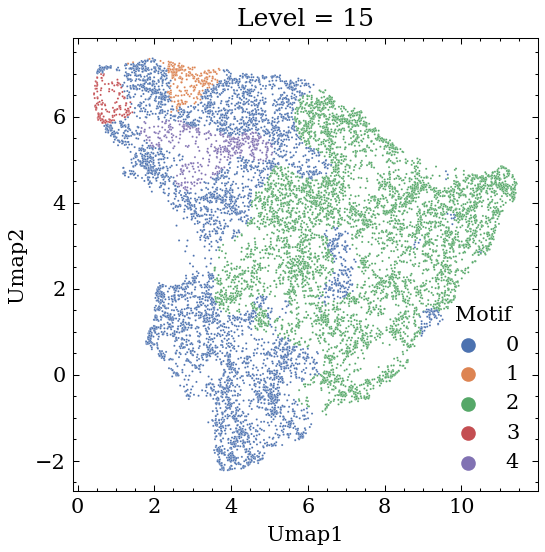

In [713]:
test_labels, strengths = hdbscan.approximate_predict(clusterer, high_level_embedding)
high_level_motif['Motif']=test_labels+1
# high_level_motif['umap1']=high_level_embedding[:,0]
# high_level_motif['umap2']=high_level_embedding[:,1]

print('shape of useful data: ',high_level_motif[high_level_motif['Motif']>0].shape[0])
fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
sns.scatterplot(data=high_level_motif[high_level_motif['Motif']>=0],x='umap1',y='umap2',hue='Motif',s=1,palette="deep")
plt.xlabel('Umap1')
plt.ylabel('Umap2')
# plt.title('Clustering of three brain regions (DBSCAN)')
# plt.title('Level = 2')
plt.title('Level = 15')
plt.show()

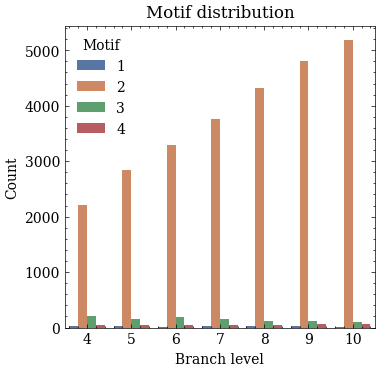

In [561]:
fig=plt.figure(figsize=(4,4),dpi=100)
plt.subplot(111)
sns.countplot(x='level',hue='Motif',data=high_level_motif[high_level_motif.Motif>0],palette="deep")
plt.xlabel('Branch level')
plt.ylabel('Count')
plt.title('Motif distribution')
plt.show()

TODO
1. 需要计算motif2的特征分布是不是和high level的数据是一致的，以此来论证高level的数据使用的都是motif2
2. 能不能逐个加入高level的node，然后进行分类

Estimated number of clusters: 6
Estimated number of noise points: 0
silhouette coefficient=0.451


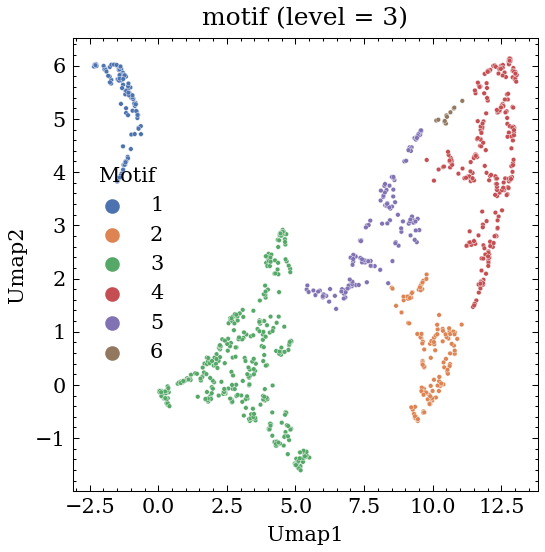

In [469]:
db = DBSCAN(min_samples=8).fit(level_embedding)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
level_motif['Motif']=db.labels_+1
kclusters=n_clusters_
centers=np.zeros([kclusters,2])
for c in np.arange(0,n_clusters_):
    tmpdf=level_motif[level_motif['Motif']==(c+1)].copy()
    centers[c,0]=tmpdf.loc[:,'umap1'].mean()
    centers[c,1]=tmpdf.loc[:,'umap2'].mean()
sc_score = silhouette_score(level_embedding, db.labels_, metric="euclidean")
print("silhouette coefficient=%0.03f" % (sc_score))

fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
sns.scatterplot(data=level_motif[level_motif['Motif']>0],x='umap1',y='umap2',hue='Motif',s=5,palette="deep")
plt.xlabel('Umap1')
plt.ylabel('Umap2')
# plt.title('Clustering of three brain regions (DBSCAN)')
# plt.title('Level = 2')
plt.title('motif (level = 3)')
plt.show()

silhouette coefficient=0.439


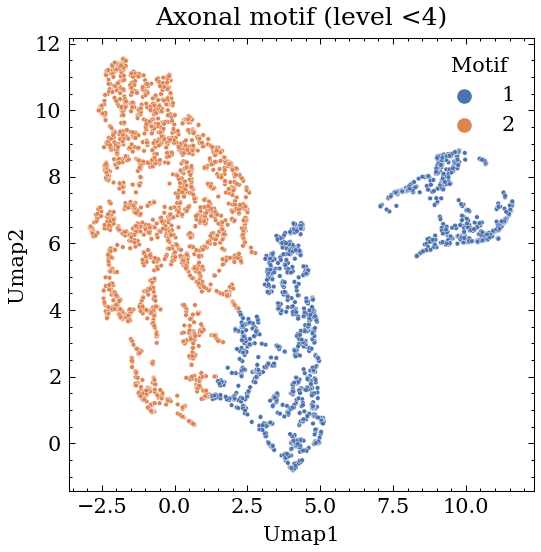

In [414]:
#Kmeans-clustering

kclusters=2
kmeansmodel = KMeans(n_clusters=kclusters,init='k-means++',random_state=3)
kmeansmodel.fit(level_embedding)
centers = kmeansmodel.cluster_centers_
level_motif['Motif']=(kmeansmodel.labels_+1)
# axon_motif['region']=axon_motif_labels['motif_region']
sc_score = silhouette_score(level_embedding, kmeansmodel.labels_, metric="euclidean")
print("silhouette coefficient=%0.03f" % (sc_score))
fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
# colors = np.array(['red','green','blue','yellow','pink'])
sns.scatterplot(data=level_motif,x='umap1',y='umap2',hue='Motif',s=5,palette="deep")
# plt.scatter(centers[:, 0], centers[:, 1], s = 10,color='black')
# plt.scatter(embedding[:, 0], embedding[:, 1], c = colors[axon_motif['Kmeans-cluster']-1], s = 0.1)
plt.xlabel('Umap1')
plt.ylabel('Umap2')
plt.title('Axonal motif (level <4)')
plt.show()

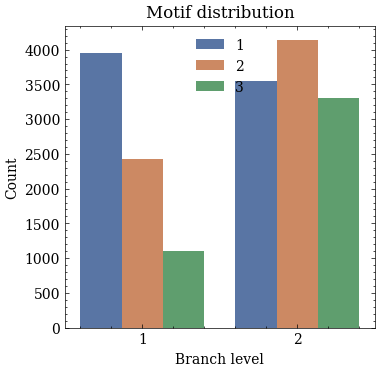

In [781]:
fig=plt.figure(figsize=(4,4),dpi=100)
plt.subplot(111)
sns.countplot(x='level',hue='Motif',data=level_motif[level_motif.Motif>0],palette="deep")
plt.xlabel('Branch level')
plt.ylabel('Count')
plt.legend(loc='upper center')
plt.title('Motif distribution')
plt.show()

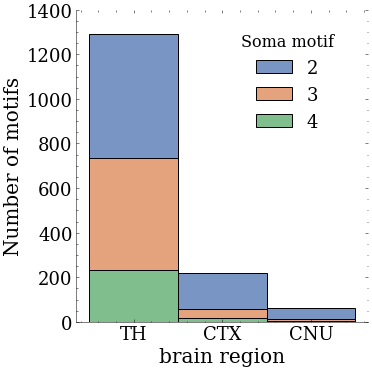

In [44]:
g=sns.displot(x='brain_region',hue='Motif',data=level_motif[level_motif.Motif>1],palette='deep',
            multiple="stack",common_norm=False,
            legend=True)
sns.move_legend(g,'upper left',bbox_to_anchor=(.5, .95),fontsize=18,title="Soma motif",title_fontsize=16)
# g.add_legend([1,2,3,4])
g.set_xticklabels(fontsize=18)
g.set_yticklabels(fontsize=18)
g.set_xlabels('brain region',fontsize=20)
g.set_ylabels('Number of motifs',fontsize=20)
# savefile=figcenter+'axon_motif_dist_in_brain_region.png'
# fig.savefig(savefile,dpi=300)
# Img2TIFF(savefile,compression='lzw')

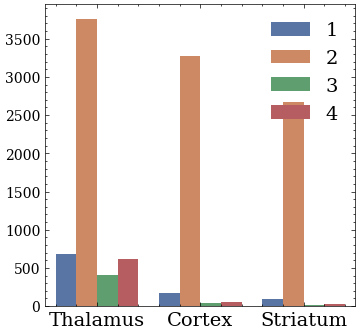

save tiff : ./internal_motif_figs/axon_motif_dist_in_brain_region.tiff


In [835]:
fig=plt.figure(figsize=(4,4),dpi=100)
plt.subplot(111)
sns.countplot(x='brain_region',hue='Motif',data=level_motif[level_motif.Motif>0],palette="deep")
# plt.xlabel('Branch type')
# plt.ylabel('Count')
# plt.title('Motif distribution')
# plt.show()
plt.xticks(rotation=0,fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.legend(fontsize=14)
# plt.tick_params(labelsize=20)
plt.show()


savefile=figcenter+'axon_motif_dist_in_brain_region.png'
fig.savefig(savefile,dpi=300)
Img2TIFF(savefile,compression='lzw')

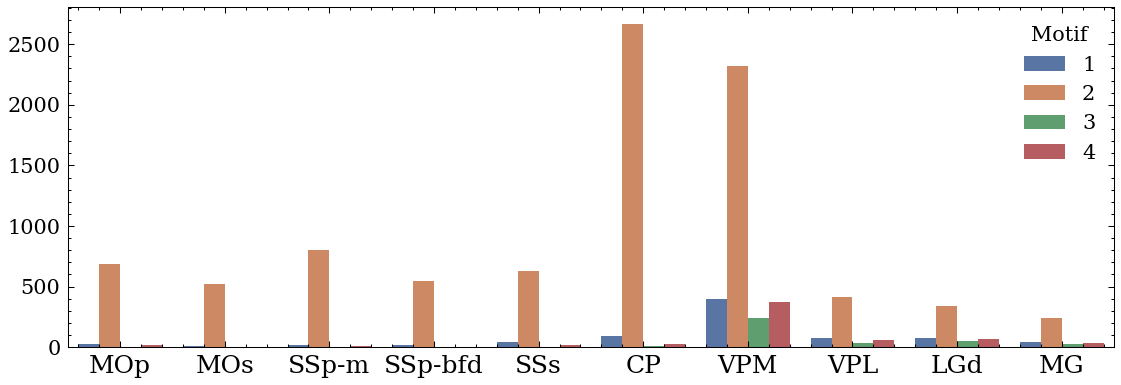

save tiff : ./internal_motif_figs/axon_motif_dist_in_soma_region.tiff


In [836]:
# brregions='CP', 'RT', 'SSp-bfd', 'VPL', 'MOp', 'MOs', 'VPM', 'VISp'
brregions=['MOp', 'MOs','SSp-m', 'SSp-bfd','SSs','CP','VPM', 'VPL', 'LGd','MG']
# brregions=['SSp-bfd', 'SSs', 'SSp-m', 'SSp-n','SSp-ll', 'SSp-un', 'SSp-ul',]
fig=plt.figure(figsize=(9,3),dpi=150)
plt.subplot(111)
sns.countplot(x='soma_region',hue='Motif',data=level_motif[(level_motif.Motif>0)&(level_motif['soma_region'].isin(brregions))],palette="deep",order=brregions)
# plt.xticks(rotation=30,fontsize=10)
# plt.xlabel('Soma region',fontsize=12)
# plt.ylabel('Count',fontsize=12)
# plt.title('Dendritic motif distribution',fontsize=12)
# plt.show()
plt.xticks(rotation=0,fontsize=12)
plt.xlabel('')
plt.ylabel('')
# plt.legend()
# plt.tick_params(labelsize=20)
plt.show()


savefile=figcenter+'axon_motif_dist_in_soma_region.png'
fig.savefig(savefile,dpi=300)
Img2TIFF(savefile,compression='lzw')

In [ ]:
corr=level_motif.drop(['umap1','umap2','soma_region','brain_region','level'],axis=1).corr('kendall')
# corr.drop(['umap1','umap2'],axis=1,inplace=True)
# print(corr['Kmeans'].sort_values())
fig=plt.figure(figsize=(4,10),dpi=100)
plt.subplot(111)
# corr=corr[(corr.Cluster>0.5)| (corr.Cluster<-0.5)].copy()
plt.barh(y=corr.index.to_list(),width=corr['Cluster'].to_list())
plt.xlim([-1,1])
plt.xlabel('Correlation Ratio (kendall)')
plt.show()

In [799]:
tfile='../motif/brdb/18864_00247.eswc/9_motif.eswc'
# swc=readswc(tfile)
def get_motif_inseg(file,type=2):
    swc=nmt.swc.neuron(file).swc
    brnode=get_bifurcation(swc)
    brs=swc2branches(swc)
    if len(brnode)==1:
        brnode=brnode[0]
        if type != swc.loc[brnode,'type']:
            return None
        for br in brs:
            if brnode == br[0]:
                outsegids=br
                break
        outseg=swc.loc[outsegids,:].copy()
        outseg.drop(['degree'],axis=1,inplace=True)
        return outseg
    return None
def get_den_motif_inseg(file):
    swc=nmt.swc.neuron(file).swc
    brnode=get_bifurcation(swc)
    brs=swc2branches(swc)
    if len(brnode)==1:
        brnode=brnode[0]
        if 2 >= swc.loc[brnode,'type']:
            return None
        for br in brs:
            if brnode == br[0]:
                outsegids=br
                break
        outseg=swc.loc[outsegids,:].copy()
        outseg.drop(['degree'],axis=1,inplace=True)
        return outseg
    return None
get_motif_inseg(tfile)

In [801]:
#for getting a neuron with all axonal motifs
import os
def readswc(file,headrow=2):
    header=['n','type','x','y','z','radius','parent']
    swc=pd.read_csv(file,sep=' ',header=None,skiprows=3)
    swc.columns=header
    swc.set_index(['n'],drop=True,inplace=True)
    return swc
def saveswc(swc,tofile,retype=None):
    header=['##n','type','x','y','z','radius','parent']
    if retype is not None:
        swc['type']=retype
    swc.reset_index(inplace=True)
    swc.to_csv(tofile,sep=' ',index=0,header=header)

outdir='../motif/viz'
selected_motifs=level_motif[(level_motif.Motif>0)&(level_motif.brain_region != 'Other')].copy()
# selected_motifs=level_motif[(level_motif.Motif>0)&(level_motif.brain_region == 'Thalamus')].copy()
selected_neurons=[]
for br in selected_motifs.index:
    nid=br.split('.csv')[0]
    selected_motifs.loc[br,'neuron']=nid
    if nid not in selected_neurons:
        selected_neurons.append(nid)
pick_cell=[]
for neuron in selected_neurons:
    sdf=selected_motifs[selected_motifs.neuron==neuron].copy()
    if sdf[sdf.Motif==1].shape[0] and sdf[sdf.Motif==2].shape[0] and sdf[sdf.Motif==3].shape[0]:
    # if sdf[sdf.Motif==1].shape[0] and sdf[sdf.Motif==2].shape[0] and sdf[sdf.Motif==3].shape[0] and sdf[sdf.Motif==4].shape[0]:
        pick_cell.append(neuron)
print(len(pick_cell),' have all type of motifs')
pnum=8
for cell in pick_cell:
    raw_cell_motif_dir=os.path.join(brpath,cell)
    to_motif_dir=os.path.join(outdir,cell)
    if not os.path.exists(to_motif_dir):
        os.mkdir(to_motif_dir)
    #scan all the motifs in target cell
    # anofile=os.path.join(to_motif_dir,'motif.ano')
    # print(anofile)
    # anof=os.open(anofile,mode='w',encoding="utf-8")
    # motiflist=[]
    for root,dirs,files in os.walk(raw_cell_motif_dir):
        for mfile in files:
            if os.path.splitext(mfile)[1] != '.eswc':
                continue
            file_in=os.path.join(root,mfile)
            file_out=os.path.join(to_motif_dir,mfile)
            # anof.write(('SWCFILE='+mfile+os.linesep))
            mid=mfile.split('_')[0]
            mindex=cell+'.csv+'+str(mid)
            mtype=5
            if mindex in selected_motifs.index:
                mtype=int(selected_motifs.loc[mindex,'Motif'])
            # rawswc=readswc(file=file_in)
            # get input seg
            rawswc=get_den_motif_inseg(file=file_in)
            if rawswc is not None:
                saveswc(rawswc,tofile=file_out,retype=mtype)
    # anof.close()
    if pnum < 1:
        break
    else:
        pnum-=1

1150  have all type of motifs


['18454_01053.eswc.csv+35', '18457_00008.eswc.csv+59', '18465_00032.eswc.csv+48', '18455_00139.eswc.csv+42', '18462_00045.eswc.csv+23', '18454_01131.eswc.csv+80', '18465_00168.eswc.csv+6', '18465_00029.eswc.csv+47']
['18464_00127.eswc.csv+61', '18455_00220.eswc.csv+29', '18867_5319_x14289_y4114.eswc.csv+21', '18864_00247.eswc.csv+21', '18457_00015.eswc.csv+32', '18867_4259_x9977_y8313.eswc.csv+47', '17302_00093.eswc.csv+6', '18869_5213_x7186_y4274.eswc.csv+28']
['17302_00052.eswc.csv+4', '18463_00038.eswc.csv+60', '17302_00094.eswc.csv+43', '18464_00191.eswc.csv+5', '18458_00376.eswc.csv+8', '18455_00126.eswc.csv+22', '18464_00132.eswc.csv+24', '17545_00110.eswc.csv+68']
['18454_00159.eswc.csv+22', '18457_00090.eswc.csv+1', '18455_00047.eswc.csv+6', '18454_01066.eswc.csv+7', '18458_00540.eswc.csv+11', '18462_00029.eswc.csv+1', '18462_00016.eswc.csv+3', '18454_00134.eswc.csv+1']


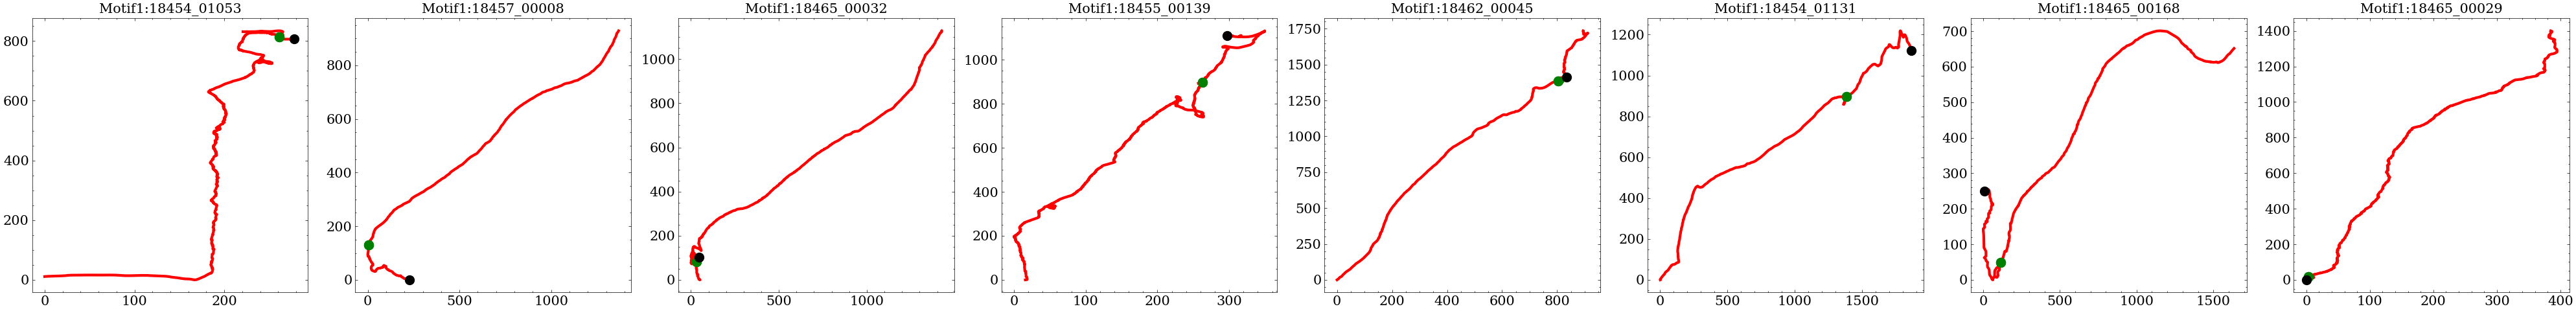

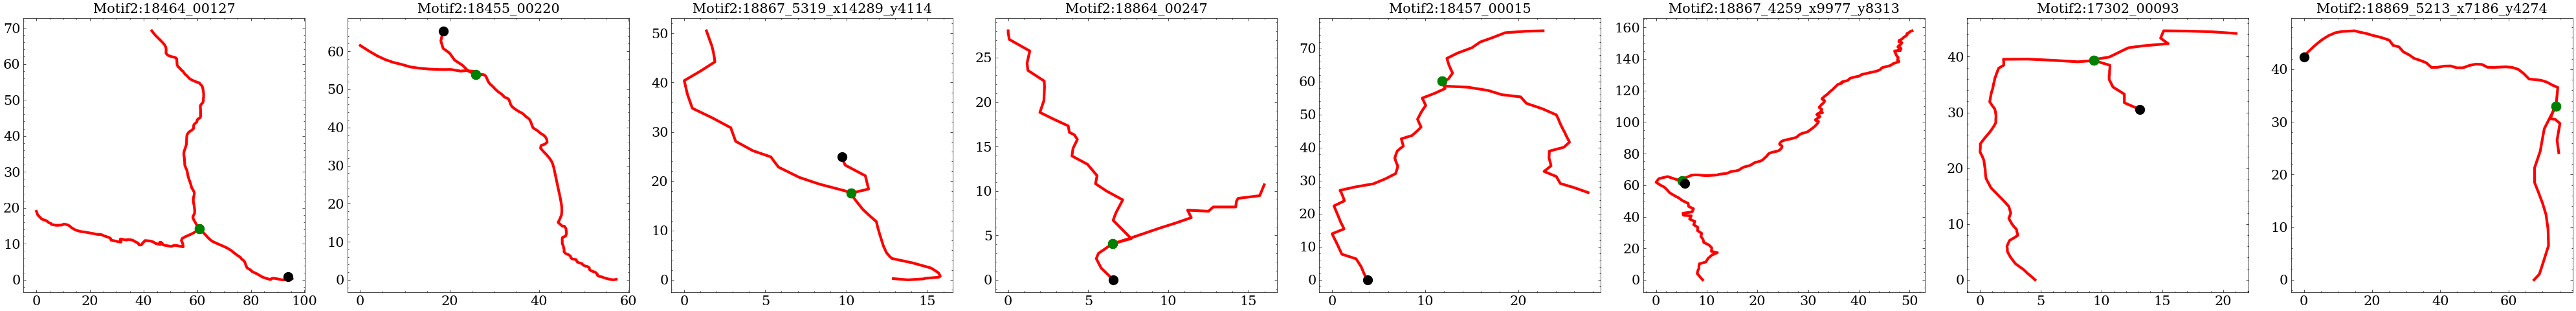

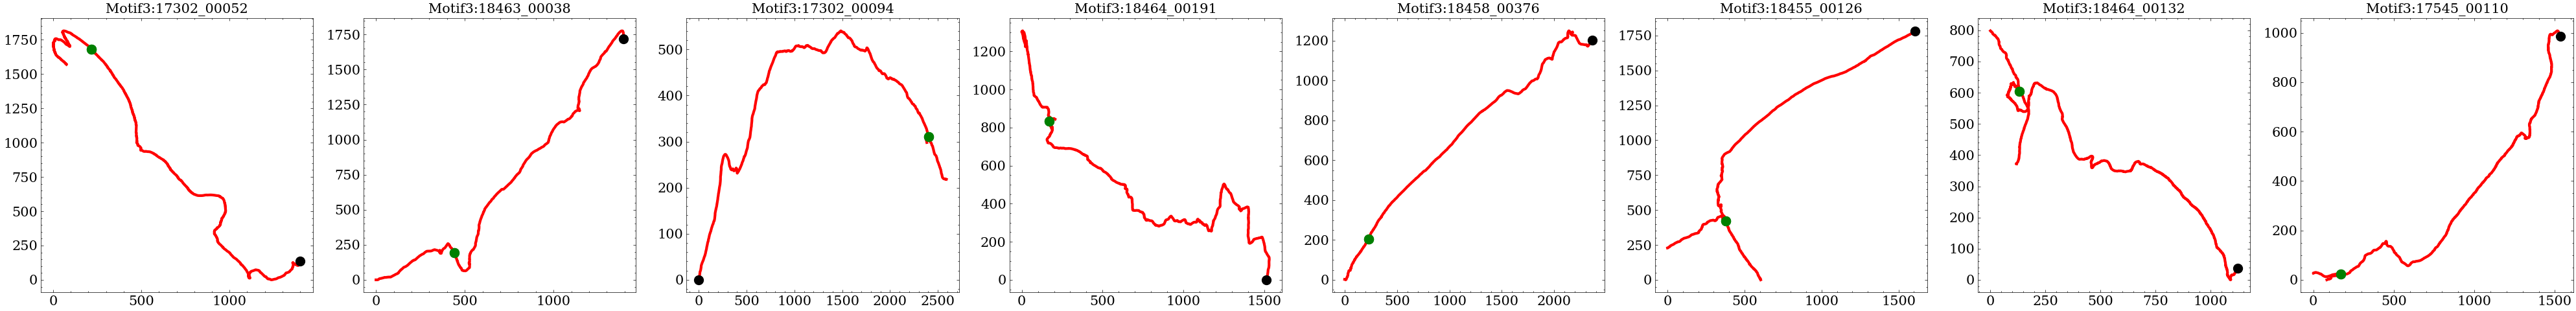

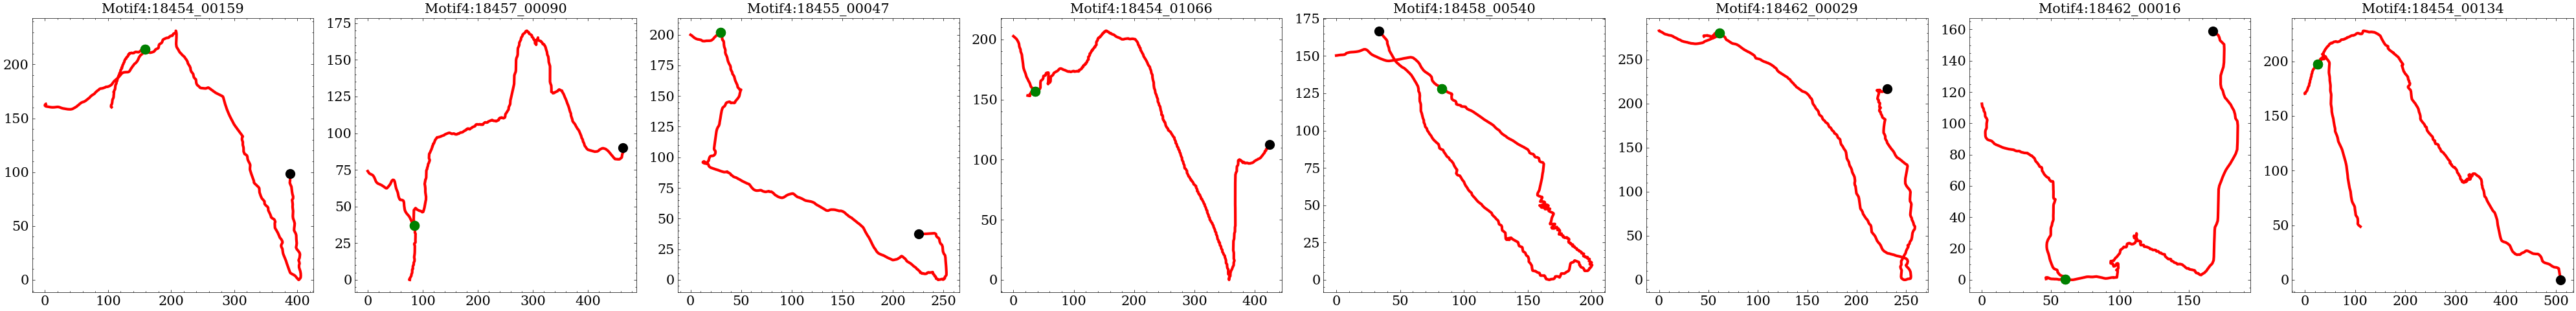

In [841]:
ana_smotifs=level_motif[level_motif.Motif>0].copy()
    # ana_motif=1
for ana_motif in np.arange(1,5):
    mdis1=0.1
    brpath='../motif/brdb'
    center_motifs=[]
    ctitles=[]
    imotifs=[]
    for dis in np.arange(1,20):
        mdis=mdis1*dis
        cmotifs=ana_smotifs[(ana_smotifs.Motif==ana_motif) 
                & (abs(ana_smotifs.umap1 - centers[ana_motif-1,0])<mdis) 
                & (abs(ana_smotifs.umap2 - centers[ana_motif-1,1])<mdis)]
        if cmotifs.shape[0] > 5:
            # print('0 shape of cluster',nc)
            break
    i=0
    for motif in cmotifs.index:
        center_motif_path=os.path.join(brpath,motif.split('.csv')[0],
                        str(motif.split('+')[1])+'_motif.eswc')
        # if i<15:
        #     i+=1
        #     continue
        if len(center_motifs)>=8:
            break

        if os.path.exists(center_motif_path):
            center_motifs.append(center_motif_path)
            imotifs.append(motif)
            ctitles.append('Motif'+str(ana_motif)+':'+motif.split('.eswc')[0])
    print(imotifs)
    motifs_plot(center_motifs,title=ctitles,fontsize=15,compare=False,linewidth=3,direction='XY',markersize=10,xylabel=False)


['Motif1: 81.6%', 'Motif2: 9.0%', 'Motif3: 6.5%', 'Motif4: 3.0%']
save tiff : ./internal_motif_figs/axonal_motifs.tiff


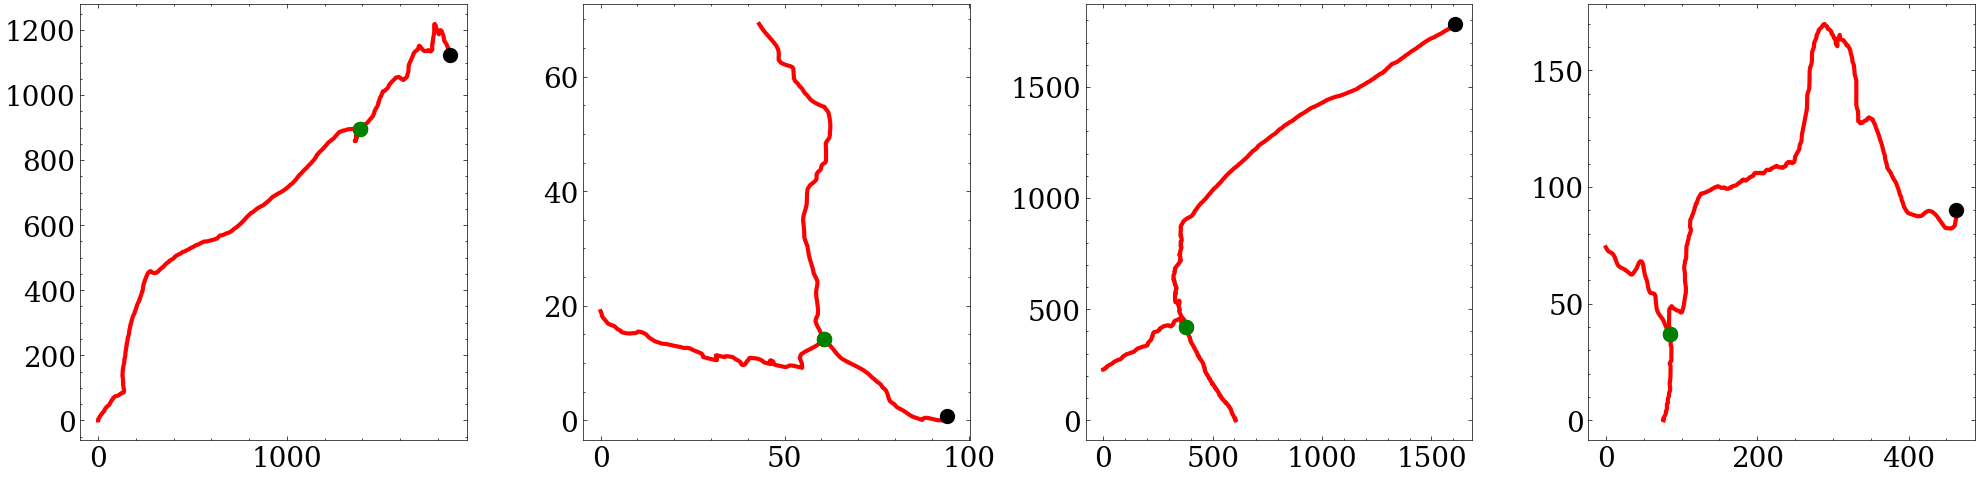

In [43]:
#axonal motifs
brpath='../motif/brdb'
preset_motifs=['18454_01131.eswc.csv+80','18464_00127.eswc.csv+61','18455_00126.eswc.csv+22','18457_00090.eswc.csv+1']
ana_smotifs=level_motif[level_motif.Motif>0].copy()
center_motifs=[]
ctitles=[]
for pi,pm in enumerate(preset_motifs):
    center_motif_path=os.path.join(brpath,pm.split('.csv')[0],
                    str(pm.split('+')[1])+'_motif.eswc')
    # center_motif_path=os.path.join(brpath,pm+'.swc')
    motif_num=round(100*ana_smotifs[(ana_smotifs.Motif==(pi+1))].shape[0]/ana_smotifs[(ana_smotifs.Motif>=1)].shape[0],1)
    if os.path.exists(center_motif_path):
        center_motifs.append(center_motif_path)
        # ctitles.append('Motif'+str(pi+1))
        ctitles.append('Motif'+str(pi+1)+': '+str(motif_num)+'%')
# print(center_motif_path)
print(ctitles)
# fig,ax=motifs_plot(center_motifs,title=ctitles,fontsize=20,compare=False,linewidth=3,direction='XY',markersize=10,xylabel=False)
fig,ax=motifs_plot(center_motifs,fontsize=20,compare=False,linewidth=3,direction='XY',markersize=10,xylabel=False)
savefile=figcenter+'axonal_motifs.png'
fig.savefig(savefile,dpi=300)
Img2TIFF(savefile,compression='lzw')

save tiff : ./internal_motif_figs/motifs.tiff


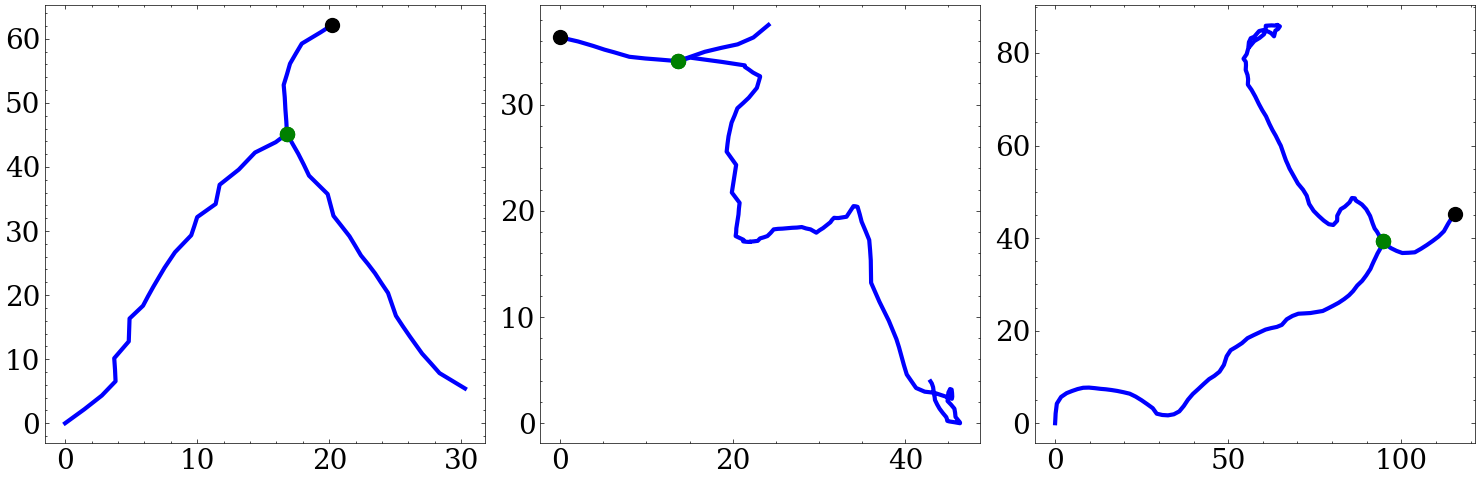

In [819]:
preset_motifs=['191812_3915_x8011_y24180.eswc.csv+12','18454_00167.eswc.csv+8','18458_00461.eswc.csv+6']
ana_smotifs=level_motif[level_motif.Motif>0].copy()
center_motifs=[]
ctitles=[]
for pi,pm in enumerate(preset_motifs):
    center_motif_path=os.path.join(brpath,pm.split('.csv')[0],
                    str(pm.split('+')[1])+'_motif.eswc')
    # center_motif_path=os.path.join(brpath,pm+'.swc')
    motif_num=round(100*ana_smotifs[(ana_smotifs.Motif==(pi+1))].shape[0]/ana_smotifs[(ana_smotifs.Motif>=1)].shape[0],1)
    if os.path.exists(center_motif_path):
        center_motifs.append(center_motif_path)
        # ctitles.append('Motif'+str(pi+1))
        ctitles.append('Motif'+str(pi+1)+': '+str(motif_num)+'%')
# print(center_motif_path)
# fig,ax=motifs_plot(center_motifs,title=ctitles,fontsize=20,compare=False,linewidth=3,direction='XY',markersize=10,xylabel=False)
fig,ax=motifs_plot(center_motifs,fontsize=20,compare=False,linewidth=3,direction='XY',markersize=10,xylabel=False)
savefile=figcenter+'motifs.png'
fig.savefig(savefile,dpi=300)
Img2TIFF(savefile,compression='lzw')

In [843]:
print(ctitles)

['Motif1: 8.0%', 'Motif2: 82.2%', 'Motif3: 3.9%', 'Motif4: 5.9%']


(<Figure size 1500x500 with 3 Axes>,
 <AxesSubplot:title={'center':'Motif3'}, xlabel='X', ylabel='Y'>)

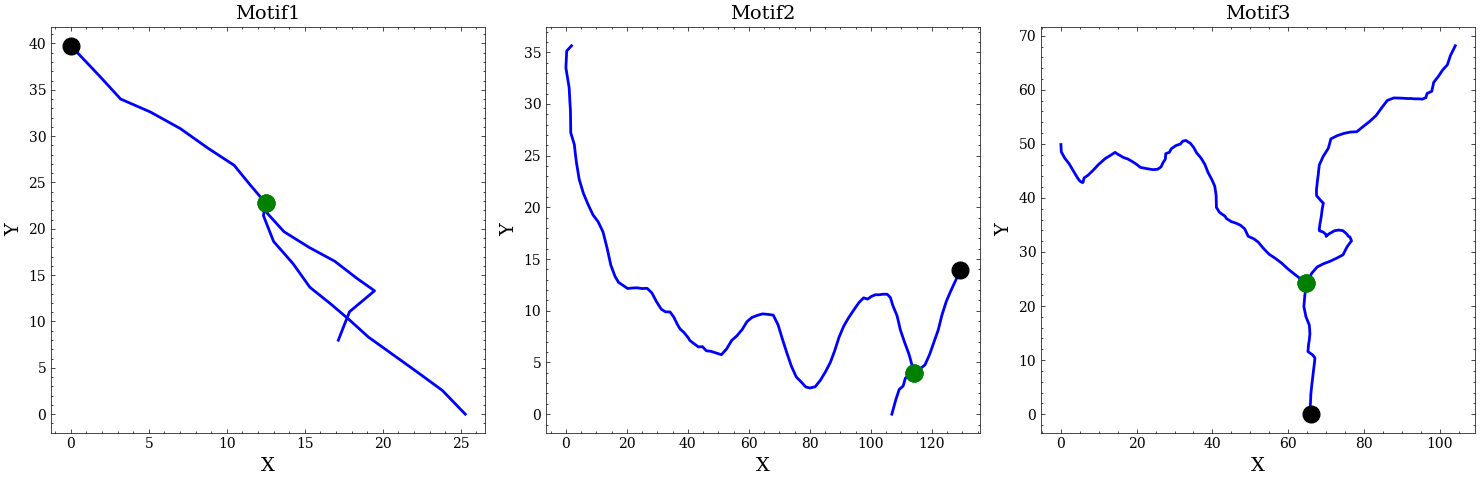

In [775]:
ana_smotifs=level_motif[level_motif.Motif>0].copy()
mdis1=0.2
center_motifs=[]
ctitles=[]
brpath='../motif/brdb'
for nc in np.arange(1,kclusters+1):
    for dis in np.arange(1,20):
        mdis=mdis1*dis
        cmotifs=ana_smotifs[(ana_smotifs.Motif==nc) 
            & (abs(ana_smotifs.umap1 - centers[nc-1,0])<mdis) 
            & (abs(ana_smotifs.umap2 - centers[nc-1,1])<mdis)]
        if cmotifs.shape[0] > 0:
            # print('0 shape of cluster',nc)
            break
    cindex=1
    center_motif_path=os.path.join(brpath,cmotifs.index.to_list()[cindex].split('.csv')[0],
                    str(cmotifs.index.to_list()[cindex].split('+')[1])+'_motif.eswc')
    if os.path.exists(center_motif_path):
        center_motifs.append(center_motif_path)
        ctitles.append('Motif'+str(nc))
# print(len(center_motifs))
# print(center_motifs)
motifs_plot(center_motifs,title=ctitles,fontsize=14,compare=False,direction='XY')

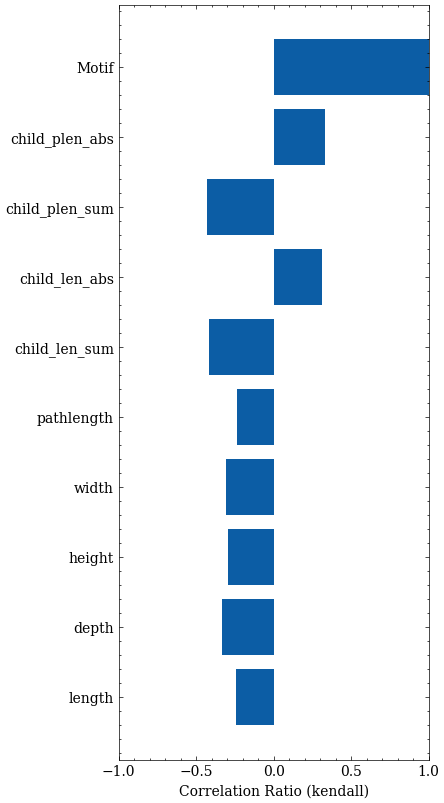

In [340]:
corr=level_motif.drop(['umap1','umap2','soma_region','brain_region','level'],axis=1).corr('kendall')
# corr.drop(['umap1','umap2'],axis=1,inplace=True)
# print(corr['Kmeans'].sort_values())
fig=plt.figure(figsize=(4,10),dpi=100)
plt.subplot(111)
# corr=corr[(corr.Cluster>0.5)| (corr.Cluster<-0.5)].copy()
plt.barh(y=corr.index.to_list(),width=corr['Motif'].to_list())
plt.xlim([-1,1])
plt.xlabel('Correlation Ratio (kendall)')
plt.show()

In [440]:
import shutil
motif_viz_dir='../motif/viz'
for index,motif_file in enumerate(center_motifs):
    outname='motif'+str(index+1)+'.swc'
    tofile=os.path.join(motif_viz_dir,outname)
    shutil.copyfile(src=motif_file,dst=tofile)

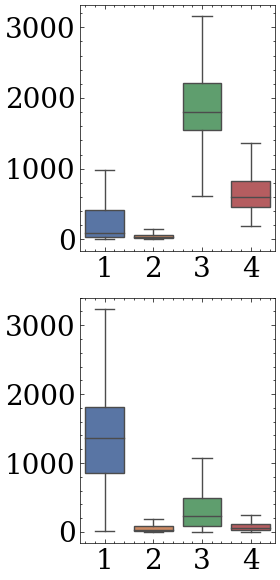

save tiff : ./internal_motif_figs/axon_motif_fea_key.tiff


In [838]:
fig=plt.figure(figsize=(3,6),dpi=100)
plt.subplot(211)
# vizdf=level_motif[['length','child_len_sum','child_len_abs','pathlength','child_plen_sum','Motif']].copy()
# vizdf['length_io_ratio']=vizdf['length']/vizdf['child_len_sum']
# vizdf['len_contraction']=vizdf['length']/vizdf['pathlength']
# vizdf['plen_contraction']=vizdf['child_len_sum']/vizdf['child_plen_sum']
sns.boxplot(y='length', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
# plt.ylabel('Input segement length (um)',fontsize=10)
plt.ylabel('')
plt.xlabel('')
plt.tick_params(labelsize=20)
# plt.ylim([-1,5800])
plt.subplot(212)
sns.boxplot(y='child_len_abs', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
# plt.ylabel('Volume size',fontsize=10)
plt.ylabel('')
plt.xlabel('')
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.show()


savefile=figcenter+'axon_motif_fea_key.png'
fig.savefig(savefile,dpi=300)
Img2TIFF(savefile,compression='lzw')

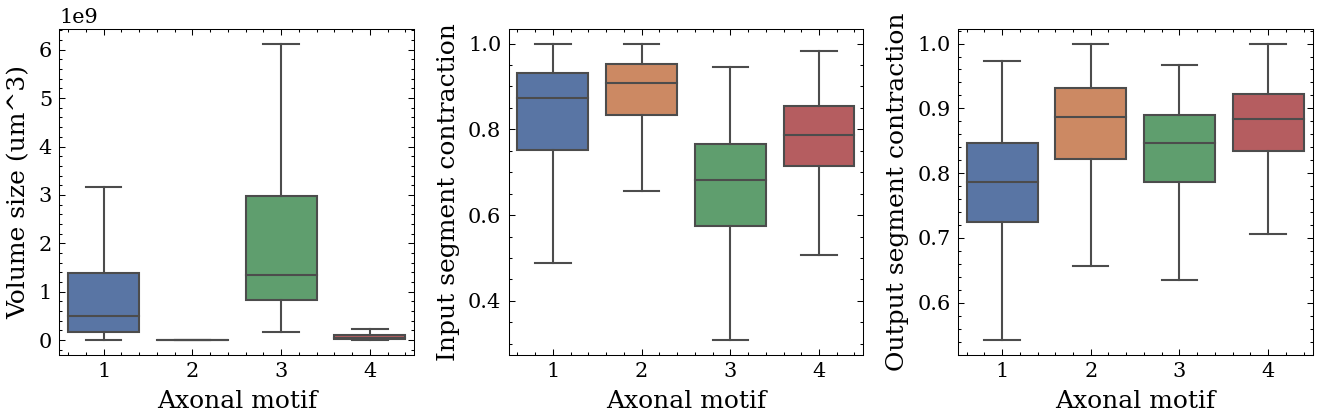

save tiff : ./internal_motif_figs/axon_motif_feas.tiff


In [839]:
#axonal motif features
fig=plt.figure(figsize=(9,3),dpi=150)
plt.subplot(131)
sns.boxplot(y='volume', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
plt.ylabel('Volume size (um^3)',fontsize=12)
# plt.ylabel('')
plt.xlabel('Axonal motif',fontsize=12)
plt.tick_params(labelsize=10)
plt.subplot(132)
sns.boxplot(y='in_contraction', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
# plt.ylabel('')
# plt.xlabel('')
plt.xlabel('Axonal motif',fontsize=12)
plt.tick_params(labelsize=10)
plt.ylabel('Input segment contraction',fontsize=12)
plt.subplot(133)
sns.boxplot(y='child_contraction_mean', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
plt.ylabel('Output segment contraction',fontsize=12)
# plt.ylabel('')
plt.xlabel('Axonal motif',fontsize=12)
# plt.xlabel('')
plt.tick_params(labelsize=10)

plt.tight_layout()
plt.show()
savefile=figcenter+'axon_motif_feas.png'
fig.savefig(savefile,dpi=300)
Img2TIFF(savefile,compression='lzw')

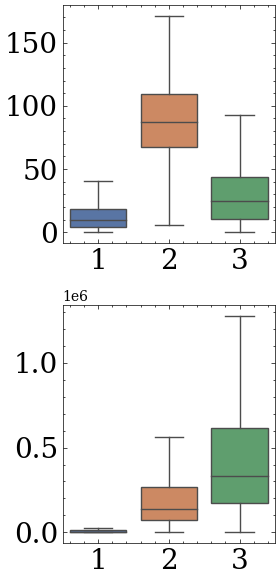

save tiff : ./internal_motif_figs/motif_fea_key.tiff


In [824]:
fig=plt.figure(figsize=(3,6),dpi=100)
plt.subplot(211)
# vizdf=level_motif[['length','child_len_sum','child_len_abs','pathlength','child_plen_sum','Motif']].copy()
# vizdf['length_io_ratio']=vizdf['length']/vizdf['child_len_sum']
# vizdf['len_contraction']=vizdf['length']/vizdf['pathlength']
# vizdf['plen_contraction']=vizdf['child_len_sum']/vizdf['child_plen_sum']
sns.boxplot(y='child_len_abs', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
# plt.ylabel('Input segement length (um)',fontsize=10)
plt.ylabel('')
plt.xlabel('')
plt.tick_params(labelsize=20)
# plt.ylim([-1,5800])
plt.subplot(212)
sns.boxplot(y='volume', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
# plt.ylabel('Volume size',fontsize=10)
plt.ylabel('')
plt.xlabel('')
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.show()


savefile=figcenter+'motif_fea_key.png'
fig.savefig(savefile,dpi=300)
Img2TIFF(savefile,compression='lzw')

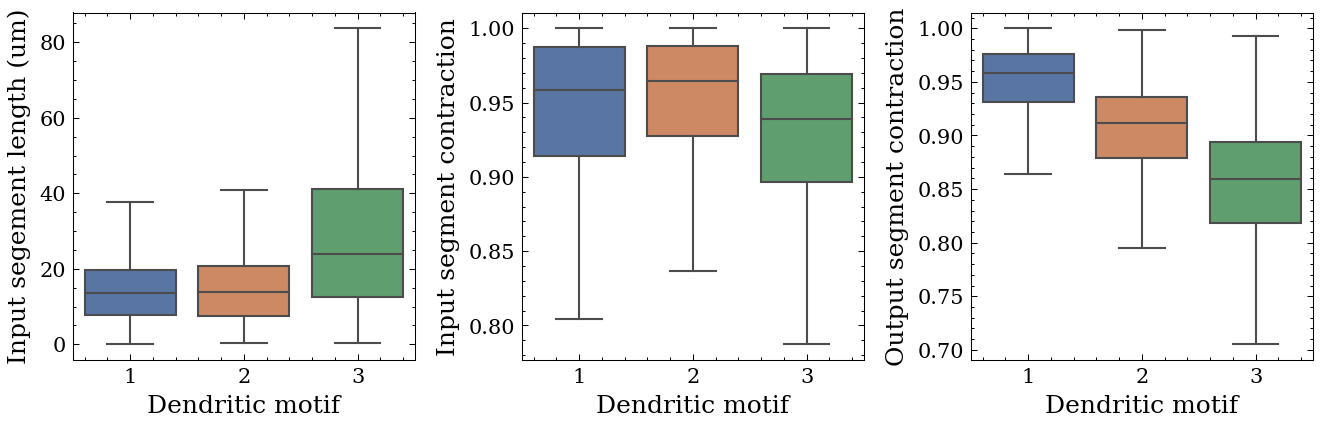

save tiff : ./internal_motif_figs/den_motif_feas.tiff


In [831]:
#dendritic motif features
fig=plt.figure(figsize=(9,3),dpi=150)
plt.subplot(131)
sns.boxplot(y='length', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
plt.ylabel('Input segement length (um)',fontsize=12)
# plt.ylabel('')
plt.xlabel('Dendritic motif',fontsize=12)
plt.tick_params(labelsize=10)
plt.subplot(132)
sns.boxplot(y='in_contraction', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
# plt.ylabel('')
# plt.xlabel('')
plt.xlabel('Dendritic motif',fontsize=12)
plt.tick_params(labelsize=10)
plt.ylabel('Input segment contraction',fontsize=12)
plt.subplot(133)
sns.boxplot(y='child_contraction_mean', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
plt.ylabel('Output segment contraction',fontsize=12)
# plt.ylabel('')
plt.xlabel('Dendritic motif',fontsize=12)
# plt.xlabel('')
plt.tick_params(labelsize=10)

plt.tight_layout()
plt.show()
savefile=figcenter+'den_motif_feas.png'
fig.savefig(savefile,dpi=300)
Img2TIFF(savefile,compression='lzw')

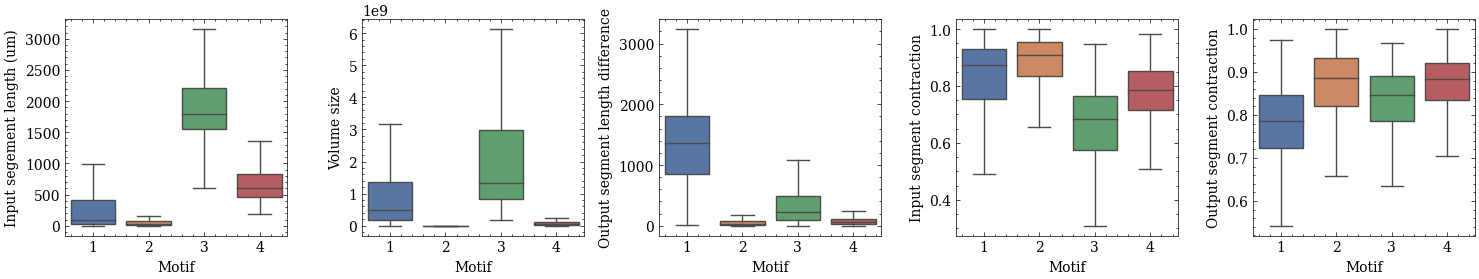

In [837]:
plt.figure(figsize=(15,3),dpi=100)
plt.subplot(151)
# vizdf=level_motif[['length','child_len_sum','child_len_abs','pathlength','child_plen_sum','Motif']].copy()
# vizdf['length_io_ratio']=vizdf['length']/vizdf['child_len_sum']
# vizdf['len_contraction']=vizdf['length']/vizdf['pathlength']
# vizdf['plen_contraction']=vizdf['child_len_sum']/vizdf['child_plen_sum']
sns.boxplot(y='length', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
plt.ylabel('Input segement length (um)',fontsize=10)
# plt.ylim([-1,5800])
plt.subplot(152)
sns.boxplot(y='volume', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
plt.ylabel('Volume size',fontsize=10)
plt.subplot(153)
sns.boxplot(y='child_len_abs', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
plt.ylabel('Output segment length difference',fontsize=10)
plt.subplot(154)
sns.boxplot(y='in_contraction', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
plt.ylabel('Input segment contraction',fontsize=10)
plt.subplot(155)
sns.boxplot(y='child_contraction_mean', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
plt.ylabel('Output segment contraction',fontsize=10)
# plt.subplot(143)
# sns.boxplot(y='angle', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
# plt.ylabel('Output segment local angle',fontsize=10)
# # plt.ylim([-1,5800])
# plt.subplot(144)
# sns.boxplot(y='angle_remote', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
# plt.ylabel('Output segment remote angle',fontsize=10)

plt.tight_layout()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'Cluster'

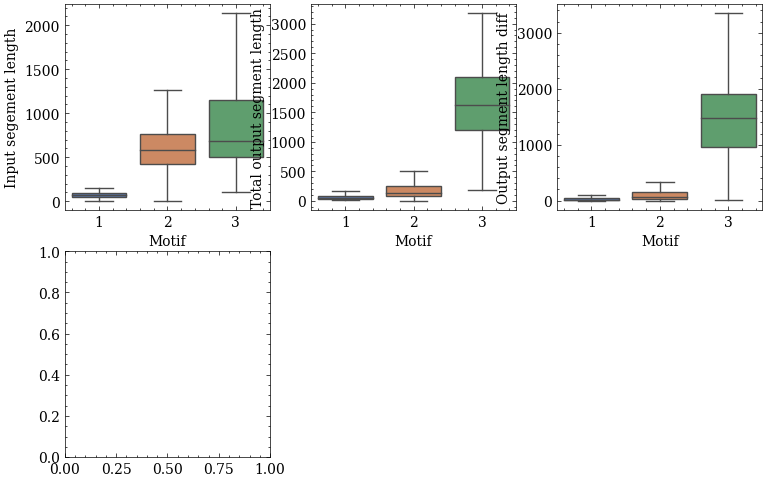

In [500]:
''' angle_io_sum', 'angle_io_abs', 'child_len_sum', child_len_abs'''
plt.figure(figsize=(9,6),dpi=100)
plt.subplot(231)
sns.boxplot(y='length', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
plt.ylabel('Input segement length',fontsize=10)
# plt.ylim([-1,5800])
plt.subplot(232)
sns.boxplot(y='child_len_sum', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
plt.ylabel('Total output segment length',fontsize=10)
# plt.ylim([-1,5800])
plt.subplot(233)
sns.boxplot(y='child_len_abs', x='Motif',data=level_motif[level_motif.Motif>0],showfliers=False,palette="deep")
plt.ylabel('Output segment length diff',fontsize=10)
# plt.ylim([-1,5800])
# plt.tight_layout()
# plt.show()
# plt.figure(figsize=(9,3),dpi=100)
plt.subplot(234)
sns.boxplot(y='angle', x='Cluster',data=level_motif[level_motif.Cluster>0],showfliers=False,palette="deep")
plt.ylabel('branching angle',fontsize=10)
# plt.ylim([-1,5800])
plt.subplot(235)
sns.boxplot(y='angle_io_sum', x='Cluster',data=level_motif[level_motif.Cluster>0],showfliers=False,palette="deep")
plt.ylabel('Total IO angle',fontsize=10)
# plt.ylim([-1,5800])
plt.subplot(236)
sns.boxplot(y='angle_io_abs', x='Cluster',data=level_motif[level_motif.Cluster>0],showfliers=False,palette="deep")
plt.ylabel('IO angle diff',fontsize=10)
# plt.ylim([-1,5800])
plt.tight_layout()
plt.show()

In [ ]:
db = DBSCAN(min_samples=30).fit(level_embedding)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
level_motif['DBSCAN']=db.labels_+1

fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
sns.scatterplot(data=level_motif[level_motif['DBSCAN']>=0],x='umap1',y='umap2',hue='DBSCAN',s=1,palette="bright")
plt.xlabel('Umap1')
plt.ylabel('Umap2')

In [471]:
axon_motif_raw=all_motif[(all_motif.type ==2)&(all_motif.brain_region != 'Other')].copy()
axon_motif_raw.drop(['radius','radius_io', 'radius_oa','type'],axis=1,inplace=True)
level_step=10
labels=[]
labels2=[]
# # level_list=np.arange(10)
for lindex in axon_motif_raw.index:
    this_level=axon_motif_raw.loc[lindex,'dist2soma']
    this_level2=axon_motif_raw.loc[lindex,'path_dist2soma']
    label=(int(this_level/level_step)+1) if this_level >= level_step else 1
    label2=(int(this_level2/level_step)+1) if this_level2 >= level_step else 1
    labels.append(label)
    labels2.append(label2)
axon_motif_raw['label_dist2soma']=labels
axon_motif_raw['label_pathdist2soma']=labels2

Index(['angle', 'angle_io1', 'angle_io1_remote', 'angle_io2',
       'angle_io2_remote', 'angle_remote', 'in_contraction', 'inlen',
       'inpathlen', 'io_len_ratio', 'io_pathlen_ratio', 'left_contraction',
       'level', 'lr_len_ratio', 'lr_pathlen_ratio', 'outLlen', 'outLpathlen',
       'outRlen', 'outRpathlen', 'right_contraction', 'label_dist2soma',
       'label_pathdist2soma'],
      dtype='object')


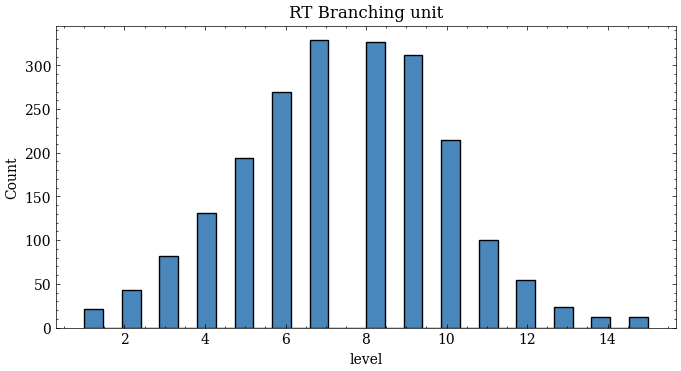

In [472]:
ntype='RT'
axon_motif=axon_motif_raw[(axon_motif_raw.level>=1) & (axon_motif_raw.level<=15)&(axon_motif_raw['soma_region']==ntype)].copy()
# level_motif=axon_motif[(axon_motif.level>=llevel) & (axon_motif.level<=hlevel)].copy()
# print('max level=',max(axon_motif.loc[:,'level']))
# print(axon_motif['level'].value_counts())
fig=plt.figure(figsize=(8,4),dpi=100)
plt.subplot(111)
sns.histplot(x='level',data=axon_motif)
plt.title(ntype+' Branching unit')
# plt.xlabel('order')

# llabels=[]
# # level_list=np.arange(10)
# for lindex in axon_motif.index:
#      this_level=axon_motif.loc[lindex,'level']
#      llabels.append(float("%.1f" % (this_level+0.2)))
# axon_motif['order']=llabels
axon_motif.drop(['dist2soma','path_dist2soma','soma_region'],axis=1,inplace=True)
print(axon_motif.keys())

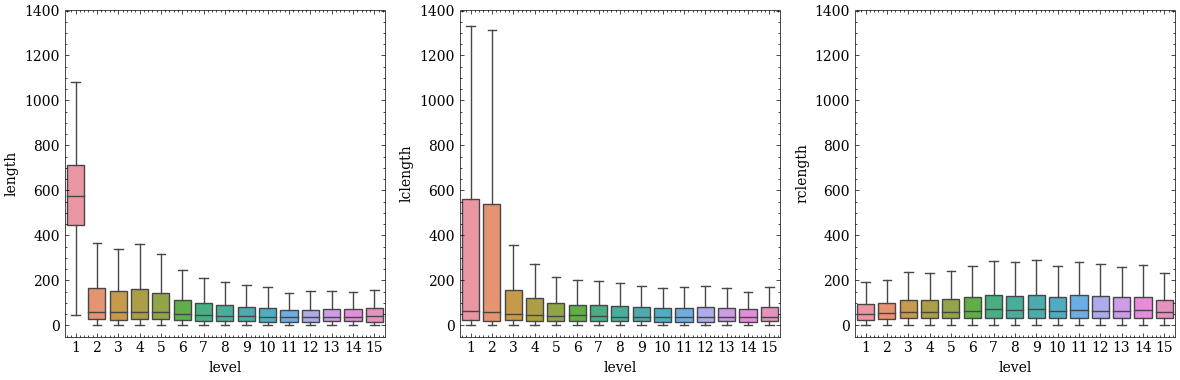

In [165]:
plt.figure(figsize=(12,4),dpi=100)
plt.subplot(131)
# plt.boxplot(level_motif['level'],level_motif['length'])
sns.boxplot(y='length', x='level',data=level_motif,showfliers=False)
plt.ylim([-50,1400])
plt.subplot(132)
sns.boxplot(y='lclength', x='level',data=level_motif,showfliers=False)
plt.ylim([-50,1400])
plt.subplot(133)
sns.boxplot(y='rclength', x='level',data=level_motif,showfliers=False)
plt.ylim([-50,1400])
plt.tight_layout()

<AxesSubplot:xlabel='level', ylabel='angle_io2'>

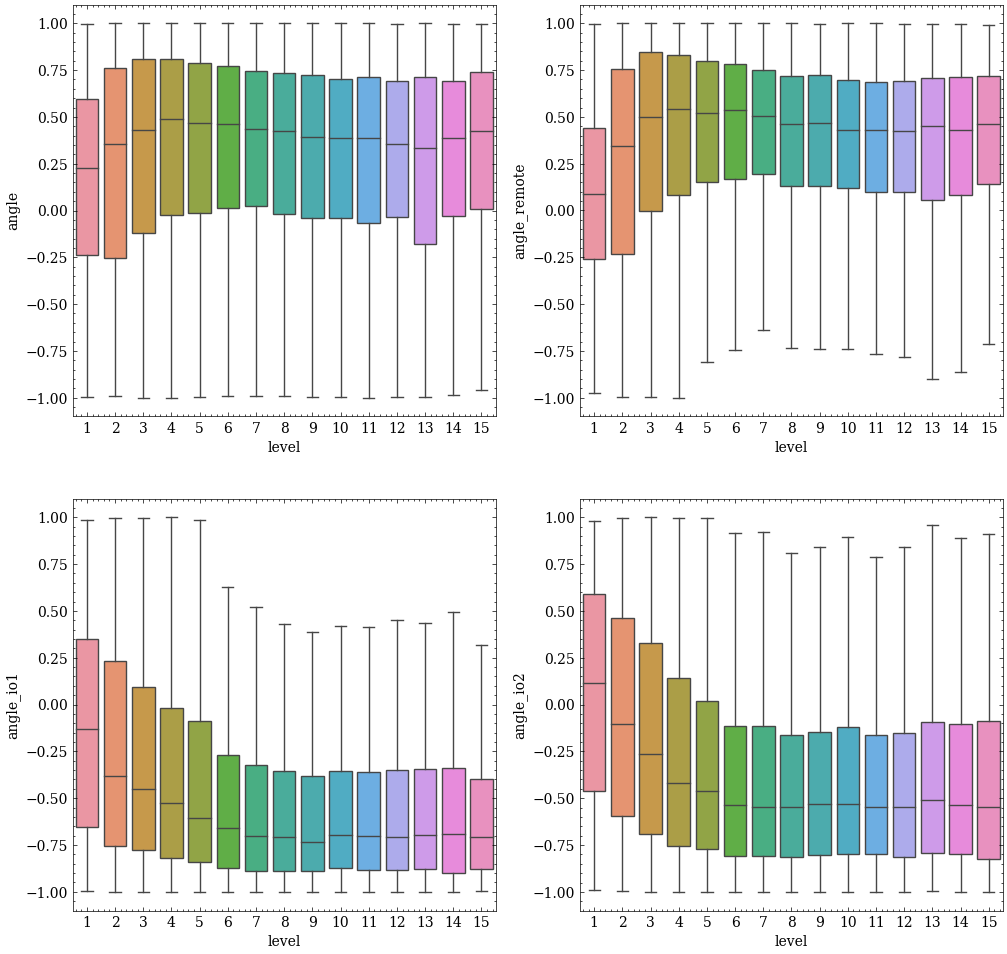

In [159]:
plt.figure(figsize=(12,12),dpi=100)
plt.subplot(221)
sns.boxplot(y='angle', x='level',data=level_motif,showfliers=False)
plt.subplot(222)
sns.boxplot(y='angle_remote', x='level',data=level_motif,showfliers=False)
plt.subplot(223)
sns.boxplot(y='angle_io1', x='level',data=level_motif,showfliers=False)
plt.subplot(224)
sns.boxplot(y='angle_io2', x='level',data=level_motif,showfliers=False)
# plt.legend(loc='upper left')

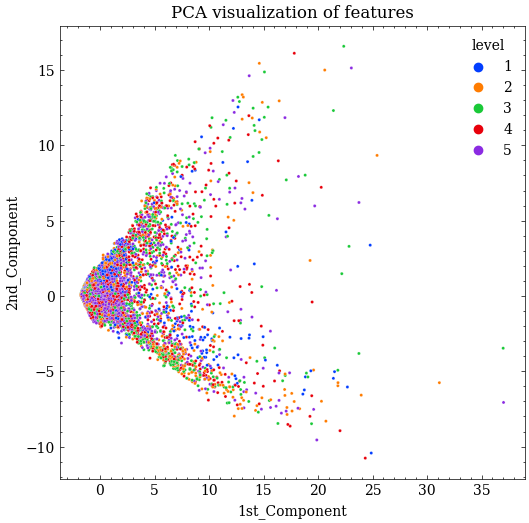

In [400]:
#PCA

from sklearn.decomposition import PCA   #导入PCA
X_pca = PCA(n_components=2).fit_transform(level_motif_s)   
# n_components为PCA的参数，所要保留的主成分个数n，也即保留下来的特征个数n
# train_x_fea为需要降维的数据
level_motif['1st_Component']=X_pca[:,0]
level_motif['2nd_Component']=X_pca[:,1]
# X_pca = np.vstack((X_pca.T, level_motif['llabel'])).T  #把降维后的数据和标签按垂直方向（行顺序）堆叠数组构成一个新的数组
# df_pca = pd.DataFrame(X_pca, columns=['1st_Component','2nd_Component','label'],index=level_motif.index)   #把降维后的数据和标签进行组合
# df_pca.head()
plt.figure(figsize=(6, 6),dpi=100)  #定义输出图像大小
sns.scatterplot(data=level_motif, hue='level',x='1st_Component',y='2nd_Component',s=5,palette='bright')   #画散点图，定义X/Y轴
plt.rcParams['xtick.direction'] = 'in'  #plt.rcParams主要作用是设置画的图的分辨率，大小等信息
plt.rcParams['ytick.direction'] = 'in'
plt.title('PCA visualization of features')  #定义标题
# plt.savefig('PCA visualization of features.jpg')  #保存图片
# plt.ylim([-3,3])
# plt.xlim([-3,3])
plt.show()

Axonal branching pattern in its branching region

In [578]:
print(all_motif['br_region'].value_counts().head(15).index)

Index(['CP', 'SSp-bfd', 'SSs', 'SSp-m', 'SSp-n', 'MOp', 'VPM', 'SSp-ul',
       'fiber tracts', 'VISp', 'MOs', 'SSp-ll', 'SSp-un', 'VPL', 'RT'],
      dtype='object')


(1104, 22)


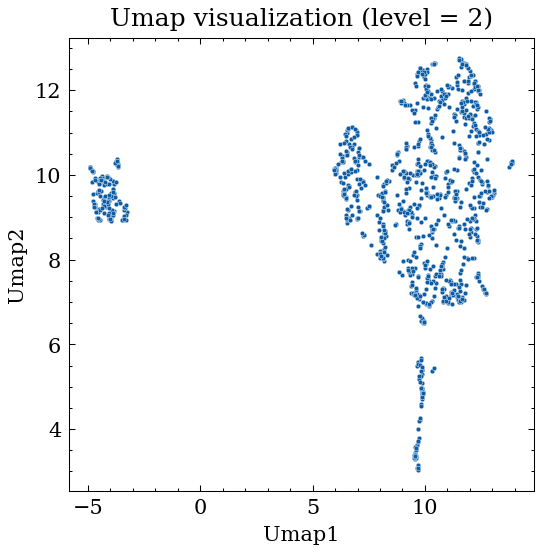

In [595]:
brregions=['CP', 'SSp-bfd', 'MOp', 'VPM', 'VISp', 'MOs','VPL', 'RT']
# brregions=['SSp-bfd', 'SSs', 'SSp-m', 'SSp-n','SSp-ll', 'SSp-un', 'SSp-ul',]
motif_raw=all_motif[(all_motif.type ==2)&(all_motif.brain_region != 'Other')&(all_motif['br_region'].isin(brregions))].copy()
motif_raw.drop(['radius','radius_io', 'radius_oa','lcradius','rcradius'],axis=1,inplace=True)
# motif_raw.keys()
al=2
level_motif=motif_raw[(motif_raw.level>=al) & (motif_raw.level<=al)].copy()
motif_values=level_motif.drop(['dist2soma','path_dist2soma','level','soma_region', 'brain_region','br_region','type'],axis=1).values
print(motif_values.shape)
level_motif_s=StandardScaler().fit_transform(motif_values)
level_embedding = umap.UMAP(n_neighbors=10,min_dist=0,random_state=3).fit_transform(level_motif_s)
level_motif['umap1']=level_embedding[:,0]
level_motif['umap2']=level_embedding[:,1]

fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
sns.scatterplot(data=level_motif,x='umap1',y='umap2',s=5,palette="deep")
plt.xlabel('Umap1')
plt.ylabel('Umap2')
plt.title('Umap visualization (level = '+str(al)+')')
plt.show()

<AxesSubplot:>

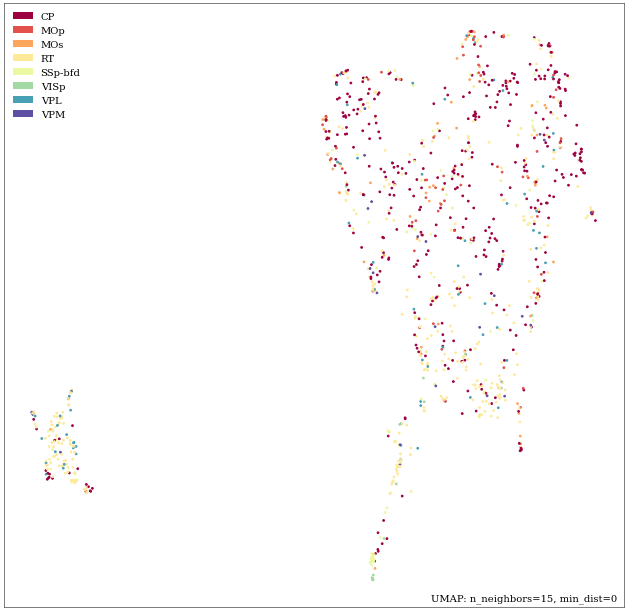

In [596]:
#umap plot
mapper = umap.UMAP(n_neighbors=15,min_dist=0,random_state=3).fit(level_motif_s)
# umap.plot.points(mapper)
umap.plot.points(mapper,labels=level_motif['br_region'])

dendritic part

(7216, 27)


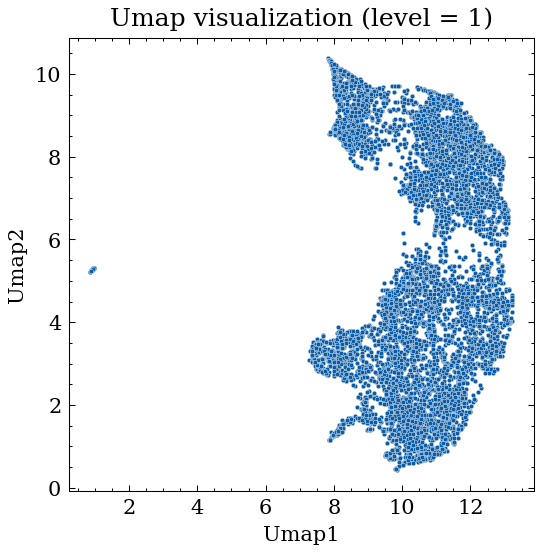

In [555]:
motif_raw=all_motif[(all_motif.type >2)&(all_motif.brain_region != 'Other')].copy()
# motif_raw.drop(['type'],axis=1,inplace=True)
# motif_raw.keys()
al=1
level_motif=motif_raw[(motif_raw.level>=al) & (motif_raw.level<=al)].copy()
motif_values=level_motif.drop(['dist2soma','path_dist2soma','level','soma_region', 'brain_region','br_region','type'],axis=1).values
print(motif_values.shape)
level_motif_s=StandardScaler().fit_transform(motif_values)
level_embedding = umap.UMAP(n_neighbors=30,min_dist=0,random_state=3).fit_transform(level_motif_s)
level_motif['umap1']=level_embedding[:,0]
level_motif['umap2']=level_embedding[:,1]

fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
sns.scatterplot(data=level_motif,x='umap1',y='umap2',s=5,palette="deep")
plt.xlabel('Umap1')
plt.ylabel('Umap2')
plt.title('Umap visualization (level = '+str(al)+')')
plt.show()

<AxesSubplot:>

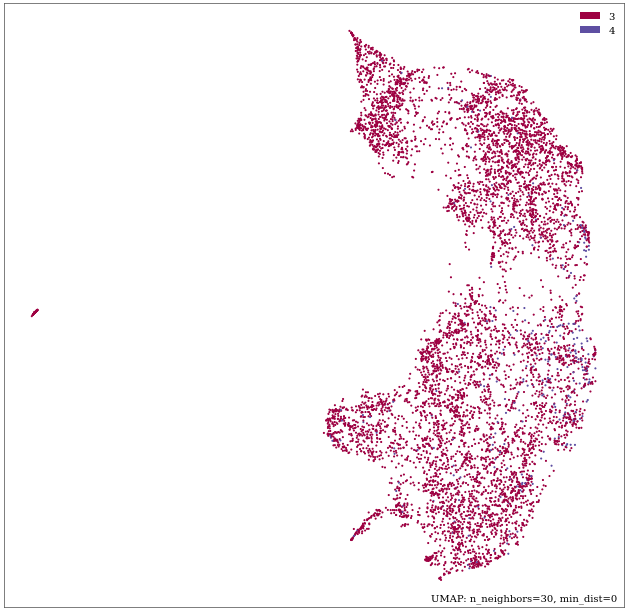

In [556]:
#umap plot
mapper = umap.UMAP(n_neighbors=30,min_dist=0,random_state=3).fit(level_motif_s)
# umap.plot.points(mapper)
umap.plot.points(mapper,labels=level_motif['type'])

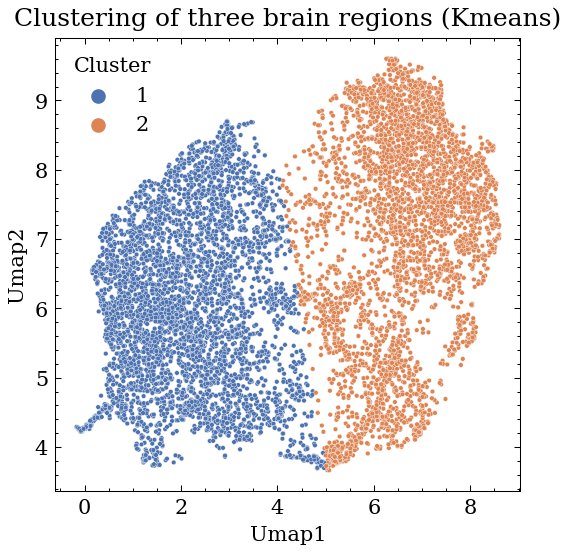

In [516]:
kmeansmodel = KMeans(n_clusters=2,init='random',random_state=3)
kmeansmodel.fit(level_embedding)
centers = kmeansmodel.cluster_centers_
level_motif['Cluster']=kmeansmodel.labels_+1
# axon_motif['region']=axon_motif_labels['motif_region']

fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
# colors = np.array(['red','green','blue','yellow','pink'])
sns.scatterplot(data=level_motif,x='umap1',y='umap2',hue='Cluster',s=5,palette="deep")
# plt.scatter(embedding[:, 0], embedding[:, 1], c = colors[axon_motif['Kmeans-cluster']-1], s = 0.1)
plt.xlabel('Umap1')
plt.ylabel('Umap2')
plt.title('Clustering of three brain regions (Kmeans)')
plt.show()

<AxesSubplot:xlabel='brain_region', ylabel='count'>

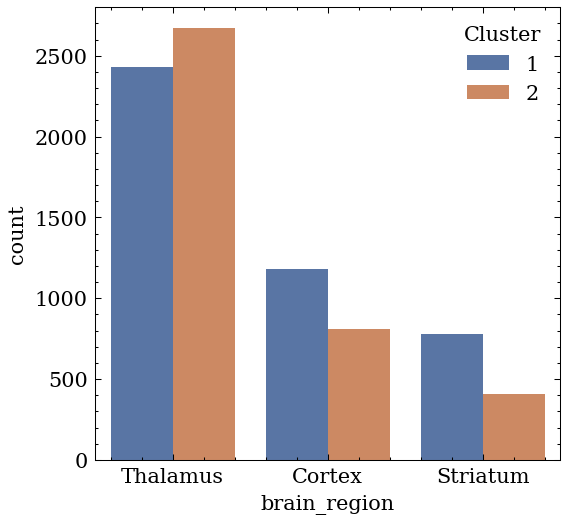

In [517]:
fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
sns.countplot(x='brain_region',hue='Cluster',data=level_motif[level_motif.Cluster>0],palette="deep")

(33, 36)
(14, 36)
Now swc:  0
Now swc:  1


(<Figure size 1000x500 with 2 Axes>,
 <AxesSubplot:title={'center':'Cluster2'}, xlabel='X', ylabel='Y'>)

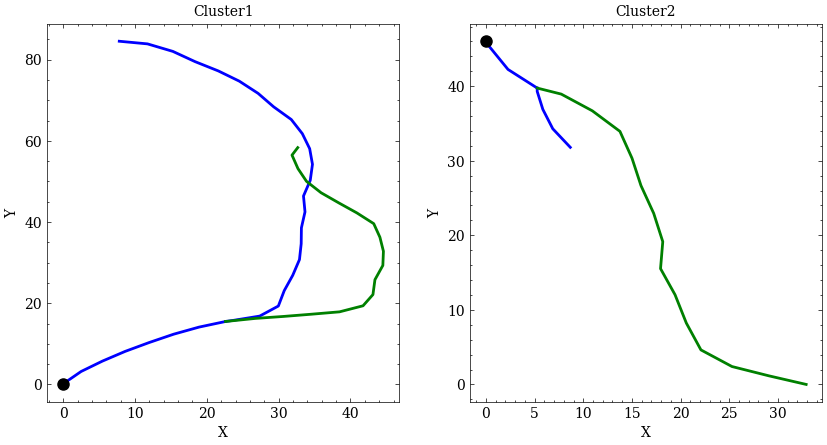

In [518]:
ana_smotifs=level_motif[level_motif.Cluster>0].copy()
mdis1=0.15
mdis2=0.1
mdis3=4.6
center_motif1=ana_smotifs[(ana_smotifs.Cluster==1) & (abs(ana_smotifs.umap1 - centers[0,0])<mdis1) & (abs(ana_smotifs.umap2 - centers[0,1])<mdis1)]
center_motif2=ana_smotifs[(ana_smotifs.Cluster==2) & (abs(ana_smotifs.umap1 - centers[1,0])<mdis2) & (abs(ana_smotifs.umap2 - centers[1,1])<mdis2)]
# center_motif3=ana_smotifs[(ana_smotifs.Cluster==3) & (abs(ana_smotifs.umap1 - centers[2,0])<mdis3) & (abs(ana_smotifs.umap2 - centers[2,1])<mdis3)]
# center_motif4=ana_smotifs[(ana_smotifs.Cluster==4) & (abs(ana_smotifs.umap1 - centers[3,0])<0.2) & (abs(ana_smotifs.umap2 - centers[3,1])<0.2)]
print(center_motif1.shape)
print(center_motif2.shape)
# print(center_motif3.shape)
# print(center_motif4.shape)

center_motifs=[]
brpath='../motif/branch_motif0815'
center_motif_path=os.path.join(brpath,center_motif1.index.to_list()[2].split('.csv')[0],
                    str(center_motif1.index.to_list()[2].split('+')[1])+'_motif.eswc')
if os.path.exists(center_motif_path):
    center_motifs.append(center_motif_path)
  
center_motif_path=os.path.join(brpath,center_motif2.index.to_list()[1].split('.csv')[0],
                    str(center_motif2.index.to_list()[1].split('+')[1])+'_motif.eswc')
if os.path.exists(center_motif_path):
    center_motifs.append(center_motif_path)

# center_motif_path=os.path.join(brpath,center_motif3.index.to_list()[0].split('.csv')[0],
#                     str(center_motif3.index.to_list()[0].split('+')[1])+'_motif.eswc')
# if os.path.exists(center_motif_path):
#     center_motifs.append(center_motif_path)
# motifs_plot(center_motifs,title=('Cluster1','Cluster2','Cluster3'),fontsize=10,compare=False)
motifs_plot(center_motifs,title=('Cluster1','Cluster2'),fontsize=10,compare=False)

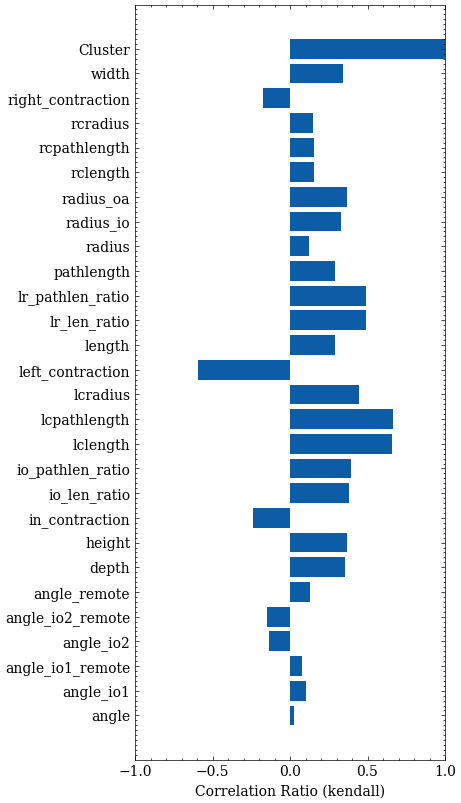

In [512]:
corr=level_motif.drop(['umap1','umap2','soma_region','brain_region','dist2soma','path_dist2soma','level','br_region'],axis=1).corr('kendall')
# corr.drop(['umap1','umap2'],axis=1,inplace=True)
# print(corr['Kmeans'].sort_values())
fig=plt.figure(figsize=(4,10),dpi=100)
plt.subplot(111)
# corr=corr[(corr.Cluster>0.5)| (corr.Cluster<-0.5)].copy()
plt.barh(y=corr.index.to_list(),width=corr['Cluster'].to_list())
plt.xlim([-1,1])
plt.xlabel('Correlation Ratio (kendall)')
plt.show()

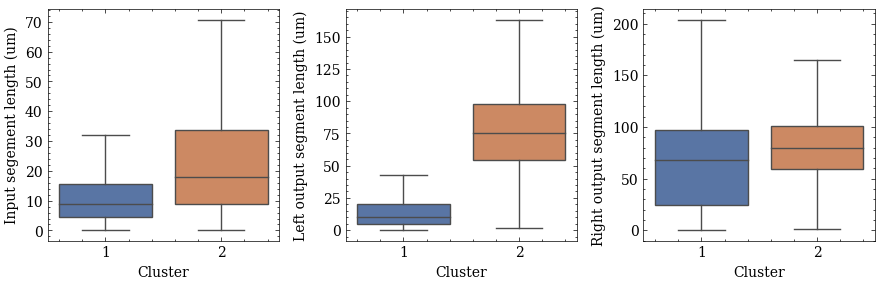

In [514]:
plt.figure(figsize=(9,3),dpi=100)
plt.subplot(131)
sns.boxplot(y='length', x='Cluster',data=level_motif[level_motif.Cluster>0],showfliers=False,palette="deep")
plt.ylabel('Input segement length (um)',fontsize=10)
# plt.ylim([-1,5800])
plt.subplot(132)
sns.boxplot(y='lclength', x='Cluster',data=level_motif[level_motif.Cluster>0],showfliers=False,palette="deep")
plt.ylabel('Left output segment length (um)',fontsize=10)
# plt.ylim([-1,5800])
plt.subplot(133)
sns.boxplot(y='rclength', x='Cluster',data=level_motif[level_motif.Cluster>0],showfliers=False,palette="deep")
plt.ylabel('Right output segment length (um)',fontsize=10)
# plt.ylim([-1,5800])
plt.tight_layout()
plt.show()

axon and dendrite comparison

(10664, 22)


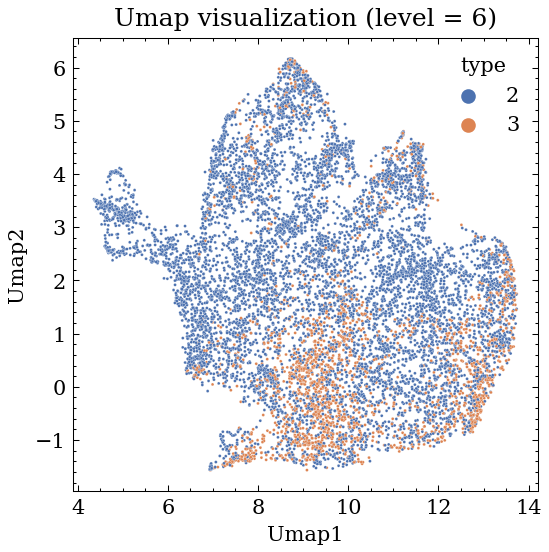

In [565]:
motif_raw=all_motif[(all_motif.type >=2)&(all_motif.type <4)&(all_motif.brain_region != 'Other')].copy()
motif_raw.drop(['radius','radius_io', 'radius_oa','lcradius','rcradius'],axis=1,inplace=True)
# motif_raw.keys()
al=6
level_motif=motif_raw[(motif_raw.level>=al) & (motif_raw.level<=al)].copy()
motif_values=level_motif.drop(['dist2soma','path_dist2soma','level','soma_region', 'brain_region','br_region','type'],axis=1).values
print(motif_values.shape)
level_motif_s=StandardScaler().fit_transform(motif_values)
level_embedding = umap.UMAP(n_neighbors=30,min_dist=0,random_state=3).fit_transform(level_motif_s)
level_motif['umap1']=level_embedding[:,0]
level_motif['umap2']=level_embedding[:,1]

fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
sns.scatterplot(data=level_motif,x='umap1',y='umap2',hue='type',s=2,palette="deep")
plt.xlabel('Umap1')
plt.ylabel('Umap2')
plt.title('Umap visualization (level = '+str(al)+')')
plt.show()

<AxesSubplot:>

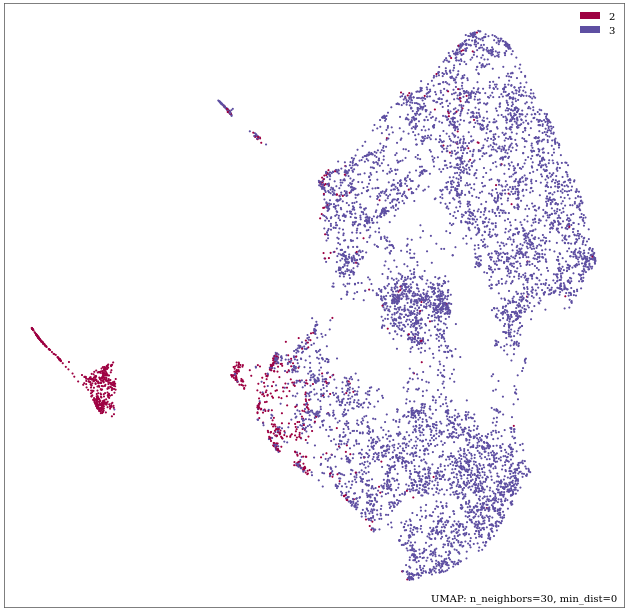

In [558]:
#umap plot
mapper = umap.UMAP(n_neighbors=30,min_dist=0,random_state=3).fit(level_motif_s)
# umap.plot.points(mapper)
umap.plot.points(mapper,labels=level_motif['type'])

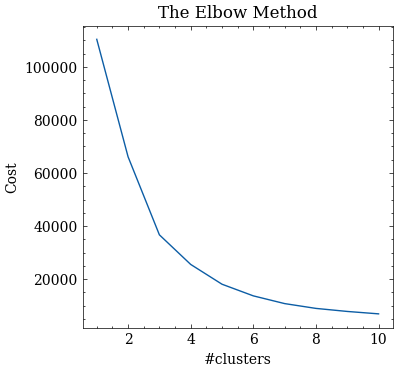

In [539]:
cost = []#初始化损失（距离）值
for i in range(1,11):#尝试不同的K值
    kmeans = KMeans(n_clusters= i ,init='k-means++', random_state =3)
    kmeans.fit(level_embedding)
    cost.append(kmeans.inertia_)#inerita_是我们选择的方法，其作用相当于损失函数

fig=plt.figure(figsize=(4,4),dpi=100)
plt.subplot(111)
plt.plot(range(1,11),cost)
plt.title('The Elbow Method')
plt.ylabel('Cost')
plt.xlabel('#clusters')
plt.show()

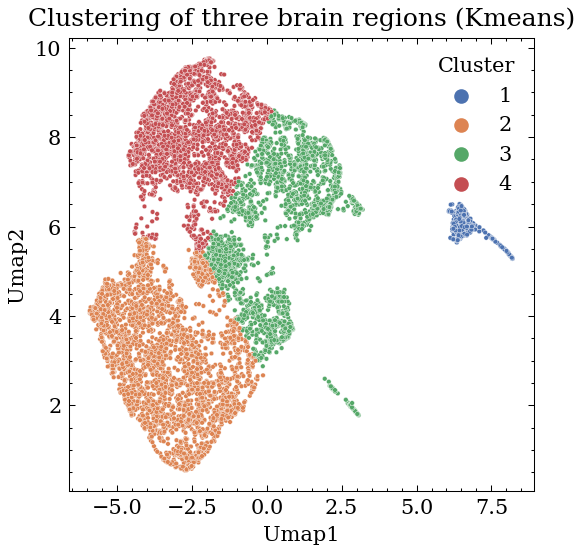

In [540]:
kmeansmodel = KMeans(n_clusters=4,init='random',random_state=3)
kmeansmodel.fit(level_embedding)
centers = kmeansmodel.cluster_centers_
level_motif['Cluster']=kmeansmodel.labels_+1
# axon_motif['region']=axon_motif_labels['motif_region']

fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
# colors = np.array(['red','green','blue','yellow','pink'])
sns.scatterplot(data=level_motif,x='umap1',y='umap2',hue='Cluster',s=5,palette="deep")
# plt.scatter(embedding[:, 0], embedding[:, 1], c = colors[axon_motif['Kmeans-cluster']-1], s = 0.1)
plt.xlabel('Umap1')
plt.ylabel('Umap2')
plt.title('Clustering of three brain regions (Kmeans)')
plt.show()

Estimated number of clusters: 5
Estimated number of noise points: 63


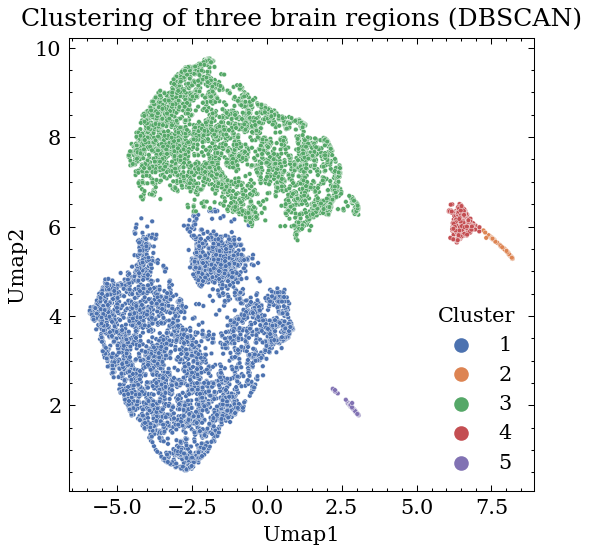

In [545]:
db = DBSCAN(min_samples=90).fit(level_embedding)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
level_motif['Cluster']=db.labels_+1

fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
sns.scatterplot(data=level_motif[level_motif['Cluster']>0],x='umap1',y='umap2',hue='Cluster',s=5,palette="deep")
plt.xlabel('Umap1')
plt.ylabel('Umap2')
plt.title('Clustering of three brain regions (DBSCAN)')
plt.show()

(156, 32)
(28, 32)
(9, 32)
Now swc:  0
Now swc:  1
Now swc:  2


(<Figure size 1500x500 with 3 Axes>,
 <AxesSubplot:title={'center':'Cluster3'}, xlabel='X', ylabel='Y'>)

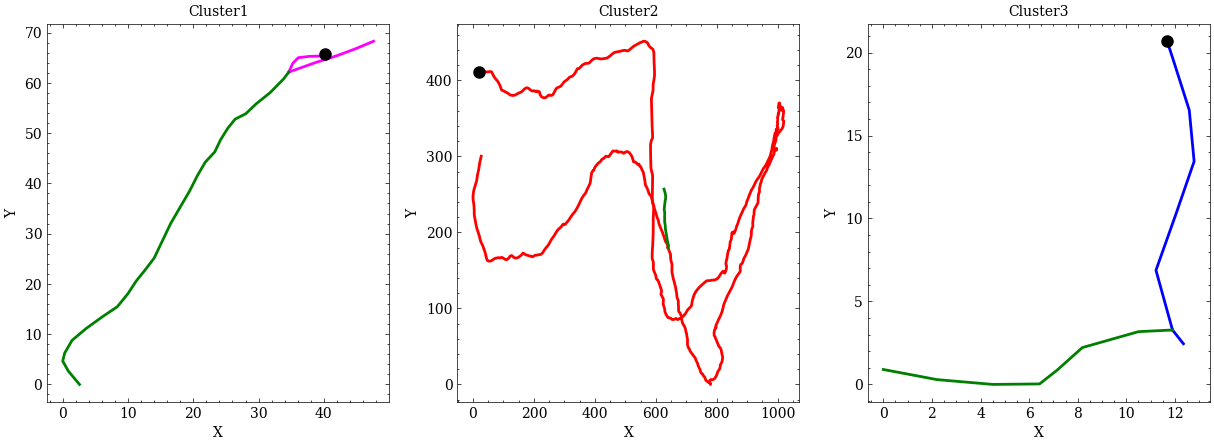

In [554]:
ana_smotifs=level_motif[level_motif.Cluster>0].copy()
mdis1=6.5
mdis2=11
mdis3=0.5
center_motif1=ana_smotifs[(ana_smotifs.Cluster==1) & (abs(ana_smotifs.umap1 - centers[0,0])<mdis1) & (abs(ana_smotifs.umap2 - centers[0,1])<mdis1)]
center_motif2=ana_smotifs[(ana_smotifs.Cluster==2) & (abs(ana_smotifs.umap1 - centers[1,0])<mdis2) & (abs(ana_smotifs.umap2 - centers[1,1])<mdis2)]
center_motif3=ana_smotifs[(ana_smotifs.Cluster==3) & (abs(ana_smotifs.umap1 - centers[2,0])<mdis3) & (abs(ana_smotifs.umap2 - centers[2,1])<mdis3)]
# center_motif4=ana_smotifs[(ana_smotifs.Cluster==4) & (abs(ana_smotifs.umap1 - centers[3,0])<0.2) & (abs(ana_smotifs.umap2 - centers[3,1])<0.2)]
print(center_motif1.shape)
print(center_motif2.shape)
print(center_motif3.shape)
# print(center_motif4.shape)

center_motifs=[]
brpath='../motif/branch_motif0815'
center_motif_path=os.path.join(brpath,center_motif1.index.to_list()[2].split('.csv')[0],
                    str(center_motif1.index.to_list()[2].split('+')[1])+'_motif.eswc')
if os.path.exists(center_motif_path):
    center_motifs.append(center_motif_path)
  
center_motif_path=os.path.join(brpath,center_motif2.index.to_list()[1].split('.csv')[0],
                    str(center_motif2.index.to_list()[1].split('+')[1])+'_motif.eswc')
if os.path.exists(center_motif_path):
    center_motifs.append(center_motif_path)

center_motif_path=os.path.join(brpath,center_motif3.index.to_list()[0].split('.csv')[0],
                    str(center_motif3.index.to_list()[0].split('+')[1])+'_motif.eswc')
if os.path.exists(center_motif_path):
    center_motifs.append(center_motif_path)
motifs_plot(center_motifs,title=('Cluster1','Cluster2','Cluster3'),fontsize=10,compare=False)
# motifs_plot(center_motifs,title=('Cluster1','Cluster2'),fontsize=10,compare=False)